<a href="https://colab.research.google.com/github/Riku-KANO/basic-ml-model/blob/main/optimization/TPE_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tree-structured Parzen Estimatorによるベイズ最適化
under construction

## Tree structured Parzen Estimator (TPE) とは

## Tree structured Parzen Estimator (TPE) の原理


### 問題設定
　まず初めに、問題設定は以下のように設定する。
$$
\newcommand{\argmin}{\mathop{\rm arg~min}\limits}
x^{+}=\argmin_{x∈ℋ} f(x)\\ 
$$

$ℋ$は入力$x$の空間、$f(x)$はブラックボックス関数、$x^{+}$はブラックボックスが出力する最小値の時の入力$x^{+}$である。我々の目標はブラックボックスが最小値を示す時の入力$x^{+}$を求めることを念頭に置いて議論を進めていく。  

### 原理
ベイズ最適化において、TPEはガウス過程回帰と同様にEIやPIなどといった獲得関数を計算する。獲得関数を計算する際、ガウス過程回帰は$p(y|x)$をベースとして以下の数式が最大になる$x$を次の探索候補点$x^*$とする。  
<br>
$$\text{EI}_{y^*}(x)=𝔼[\max(y^{*}-y, 0)]=∫^{∞}_{-∞}\max(y^{*}-y, 0)p_M(y|x)dy$$
<br>
ここで、$y^*$は閾値(threshold)であり、多くの場合では今まで得られた中での$y$の最大値が用いられる。また、$p_M(y|x)$はガウス過程モデルが推定する尤度である。
<br>
　一方でTPEでは$p(x|y)$や$p(y)$を用いて獲得関数を計算する(実際には$p(y)$をモデリングすることはないので実質的には$p(x|y)$のみを考えていくことになる)。TPEでは$p(x|y)$は以下のように定義される。  
<br>
\begin{equation}
  p(x|y)=
  \begin{cases}
    l(x) & \text{if} \ y\lt y^{*}, \\
    g(x) & \text{if} \ y\ge y^{*}, \\
  \end{cases}
\end{equation}
<br>
$l(x)$と$g(x)$は（カーネル）密度であり、$y^{*}$は閾値(threshold)である。$y^{*}$を基準としてそれを超える、またはそれを超えないデータの密度を計算(推定)している。そのデータの推定密度を用いて事後確率を計算している。$y^{*}$の選択方法に関しては$\gamma=p(y < y^{*})$となるような$y^{*}$を選択する。$\gamma$は0から1の間の値をとる実数であり、$\gamma=0.5$とした場合はデータが半々になるような$y^{*}$を選択することを指す。つまり$\gamma$は分位値(quantile)である。  
　以上を踏まえると獲得関数は以下のように記述される。  
<br>
$$\text{EI}_{y^{*}}(x)=\int^{y^{*}}_{-∞}(y^{*}-y)p(y|x)dy=\int^{y^{*}}_{-∞}(y^{*}-y)\frac{p(x|y)p(y)}{p(x)}dy$$
<br>
ここで、  
<br>
$$p(x)=\int_{ℝ}p(x|y)p(y)dy=\gamma l(x)+(1-\gamma)g(x)$$
<br>
であり、
<br>
$$\int^{y^{*}}_{-∞}(y^{*}-y)p(x|y)p(y)dy=l(x)\int^{y^{*}}_{-∞}(y^{*}-y)p(y)dy=\gamma y^{*}l(x)-l(x) \int^{y^{*}}_{-∞}p(y)dy$$
<br>
であるので、これらの２式を上式の獲得関数の式に代入すると、以下の式が得られる。  
<br>
$$\text{EI}_{y^{*}}(x)=\frac{\gamma y^{*}l(x)-l(x)\int^{y^{*}}_{-∞}p(y)dy}{\gamma l(x)+(1-\gamma)g(x)}∝\left(\gamma + \frac{g(x)}{l(x)}(1-\gamma)\right)^{-1}$$
<br>
この式から、獲得関数が$g(x)/l(x)$のみに依存しているということがわかる。

## カーネル密度推定
カーネル密度推定はここではsklearnを用いて行うことにする。

### カーネル密度推定とは
カーネル密度推定とはデータの分布をノンパラメトリックに分布を予測する手法である。正規分布や二項分布はパラメトリックモデルと呼ばれているのは、その分布が複数のパラメータのみによって記述されるからである。ノンパラメトリックモデルでは分布を支配するパラメータの存在を仮定しない。  
具体的には$i$番目のデータを$X_i$として表すと以下の式で分布$p$を推定する。
$$\hat{p}=\frac{1}{nh}\sum_{i=1}^{n}K\left(\frac{x-X_i}{h}\right)$$
ここで$K$はカーネル関数, $h$はバンド幅である。この式が意味するように、今まで取得してきたデータ点$X_i$の個数だけカーネル関数を足し合わせることを行う。この処理のイメージとしては、データ点$X_i$の周りに山を作成し、それらを重ね合わせて１つの山($\hat{p}$)を作るイメージとなる。

### カーネルの種類
sklearnで利用できるカーネルの種類は全部で６種類ある。カーネルの形状は次のコードに図示されている。

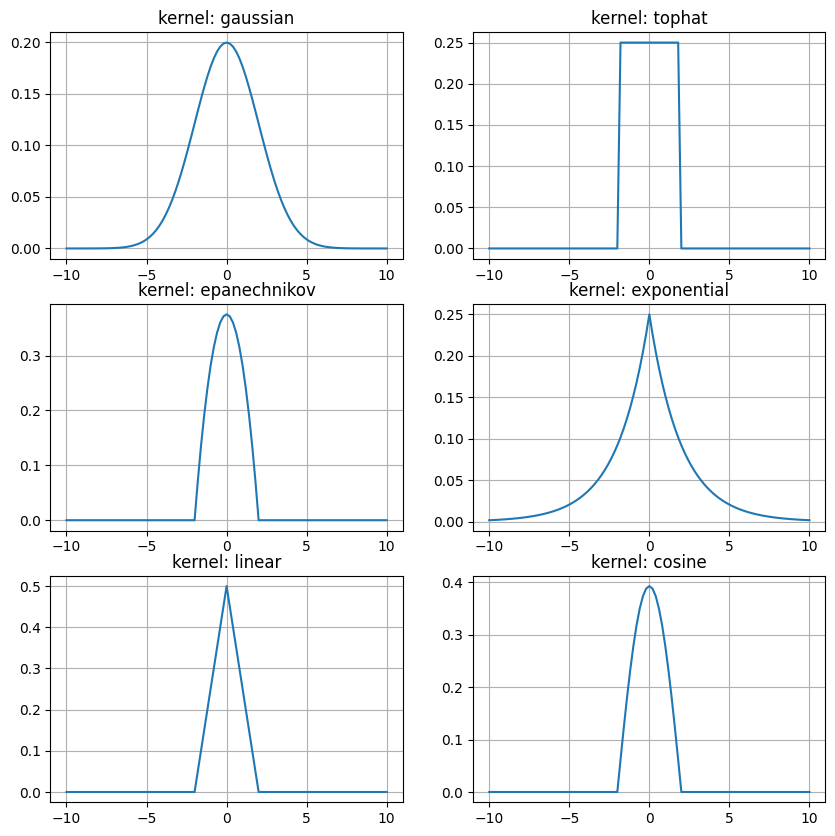

In [4]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
x = np.linspace(-10, 10, 101)
fig, ax=plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
for i, kernel in enumerate(kernels):
    model = KernelDensity(bandwidth=2, kernel=kernel)
    model.fit([[0]])
    ax[i//2, i%2].plot(x, np.exp(model.score_samples(x.reshape(-1, 1))))
    ax[i//2, i%2].set_title(f"kernel: {kernel}")
    ax[i//2, i%2].grid(True)
  
plt.show()

現時点で得られているデータが$x=-3, 0, 3$であり、バンド幅が2であるとすると以下のようにカーネル密度推定が行われる。

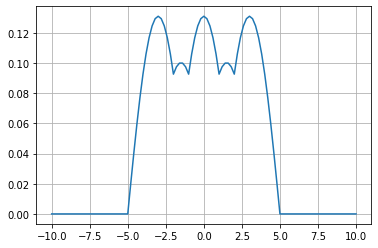

In [ ]:
model = KernelDensity(bandwidth=2, kernel=kernel)
model.fit([[0], [-3], [3]])
plt.plot(x, np.exp(model.score_samples(x.reshape(-1, 1))))
plt.grid(True)
plt.show()

## 最適化

In [2]:
GAMMA=0.2
SEED = 42
N_LOOP = 190
N_SUGGEST=30
KERNEL = "gaussian"

DEBUG=True

In [60]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy import stats

class Sampler:
    def __init__(self, init_data_x, init_data_y, n_suggest, gamma, rng, kernel):
        self.data_x = init_data_x
        self.data_y = init_data_y
        self.n_suggest = n_suggest
        self.gamma = gamma
        self.rng = rng
        self.kernel = kernel
        self.best = np.argmin(self.data_y)
        self.best_id = np.argmin(self.data_y)

    def sample(self, start, end):
        next_x = self.rng.rand(self.n_suggest) * (end-start) + start 
        EIs = self.calc_EI(next_x, start, end)
        next_idx = np.argmax(EIs)
        self.data_x = np.append(self.data_x, next_x[next_idx])
        return next_x[next_idx]

    def calc_EI(self, x: np.ndarray,  start, end):
        return np.reciprocal(self.gamma + self.calc_parzen_estimator(x, start, end) * (1 - self.gamma))

    def calc_parzen_estimator(self, x: np.ndarray, start, end):
        data = np.hstack([self.data_x.reshape(-1, 1), self.data_y.reshape(-1, 1)])
        data = data[np.argsort(data[:, -1])] # yの値でsort
        # kde_g = KernelDensity(bandwidth=3, kernel=self.kernel)
        # kde_l = KernelDensity(bandwidth=3, kernel=self.kernel)
        # kde_g.fit(data[:, :-1])
        # kde_l.fit(data[:, :-1])
        border_id = min(25, int(self.gamma * data.shape[0]))
        x_g = np.sort(data[-border_id:, :-1].ravel())[::-1]
        x_l = np.sort(data[:border_id, :-1].ravel())
        kde_g = stats.gaussian_kde(x_g, 0.5) # band幅要変更
        kde_l = stats.gaussian_kde(x_l, 0.5)
        g = kde_g(x)
        # g = kde_g.score_samples(x.reshape(-1, 1))
        l = kde_l(x)
        # l = kde_l.score_samples(x.reshape(-1, 1))
        if DEBUG:
            xargs = np.linspace(start, end, 101)
            plt.plot(xargs, kde_g(xargs), label="g")
            plt.plot(xargs, kde_l(xargs), label="l")
            plt.legend()
            plt.show()

        ret = g * np.reciprocal(l)
        ret[l < 1e-8] = 1e6
        return ret

    def update(self):
        self.best = np.min(self.data_y)
        self.best_id = np.argmin(self.data_y)

class TPE:
    def __init__(
        self, 
        data_x=None,
        data_y=None,
        seed=None,
        gamma=0.5,
        n_suggest=30,
        n_trial = 10, 
        objective=None,
        kernel = "gaussian",
        ):
        self.data_x = data_x
        self.data_y = data_y
        self.rng = np.random.RandomState(seed=seed)
        self.gamma = gamma
        self.n_suggest = n_suggest
        self.n_trial = n_trial
        self.parameter_space = None
        self.objective = objective
        self.kernel = kernel
        self.sampler = Sampler(self.data_x, self.data_y, self.n_suggest, self.gamma, self.rng, self.kernel)
        self.history = []

    def search(self):
        for i in range(self.n_trial):
            print(f"[TRIAL: {i+1:04d}]##########")
            score = self.objective(self.sampler)
            self.history.append(score)
            self.sampler.data_y = np.append(self.sampler.data_y, score)
            self.sampler.update()
            print(f"score: {score}")
            print("best trial is {}".format(self.sampler.best_id))
            # print(self.sampler.data_y)


def objective(sampler):
    x = sampler.sample(-16, 16)
    return x**4 / 1000 * np.sin(x)  + x ** 3 / 1000 - x ** 2 / 10 - x / 100 - 0.1 * np.random.rand()

def BBF(x):
    if "__len__" in dir(x):
        return x** 4 / 1000 * np.sin(x) + x ** 3 / 1000 - x ** 2 / 10 - x / 100 - 0.1 * np.random.rand(len(x))
    else:
        return x** 4 / 1000 * np.sin(x) + x ** 3 / 1000 - x ** 2 / 10 - x / 100 - 0.1 * np.random.rand()


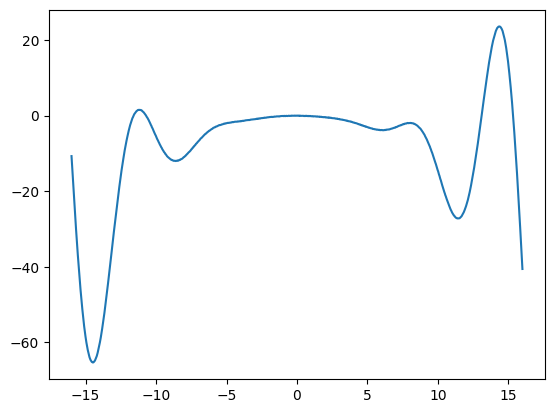

In [27]:
xargs = np.linspace(-16, 16, 1001)
y = BBF(xargs)
plt.plot(xargs, y)

[-12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12]
[TRIAL: 0001]##########


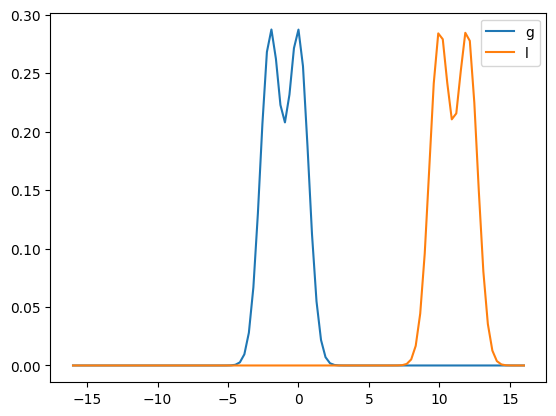

score: 23.55078394132179
best trial is 12
[TRIAL: 0002]##########


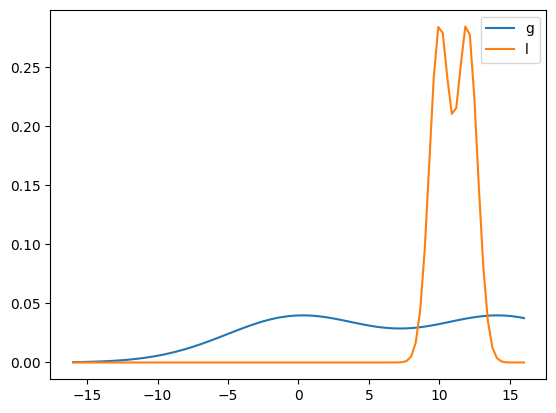

score: -12.968733755642358
best trial is 12
[TRIAL: 0003]##########


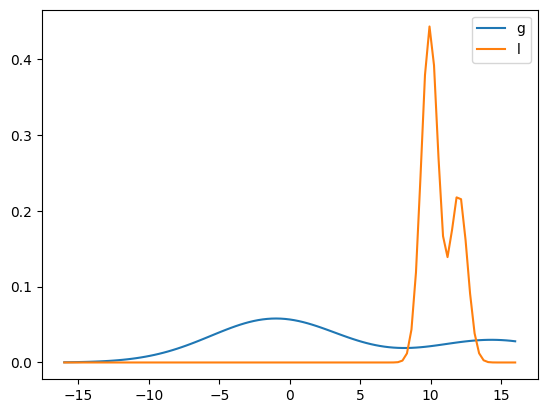

<ipython-input-60-cdcec38be397>:50: RuntimeWarning: divide by zero encountered in reciprocal
  ret = g * np.reciprocal(l)


score: -15.72953773750527
best trial is 12
[TRIAL: 0004]##########


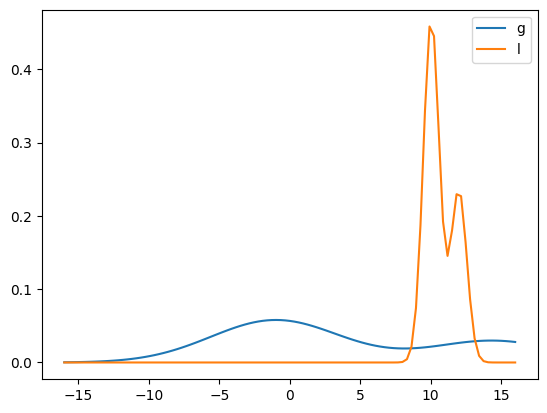

score: -12.875569851810475
best trial is 12
[TRIAL: 0005]##########


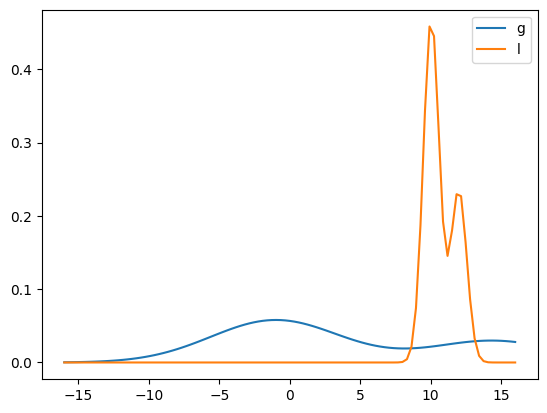

score: -16.78014199929855
best trial is 12
[TRIAL: 0006]##########


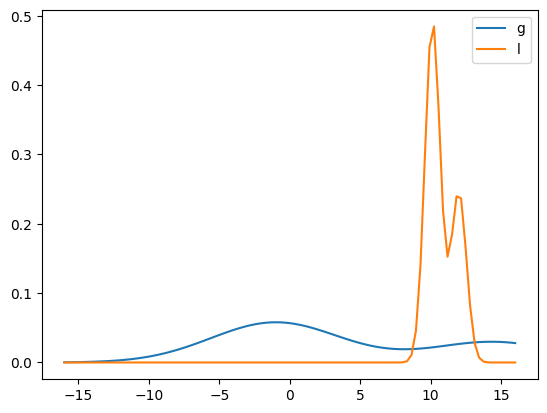

<ipython-input-60-cdcec38be397>:50: RuntimeWarning: overflow encountered in reciprocal
  ret = g * np.reciprocal(l)


score: -23.21605752101073
best trial is 12
[TRIAL: 0007]##########


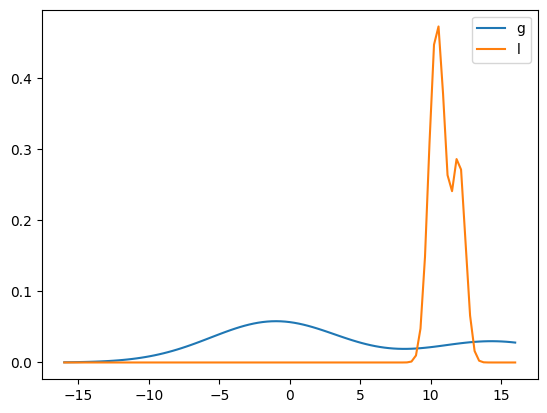

score: -16.441058716342283
best trial is 12
[TRIAL: 0008]##########


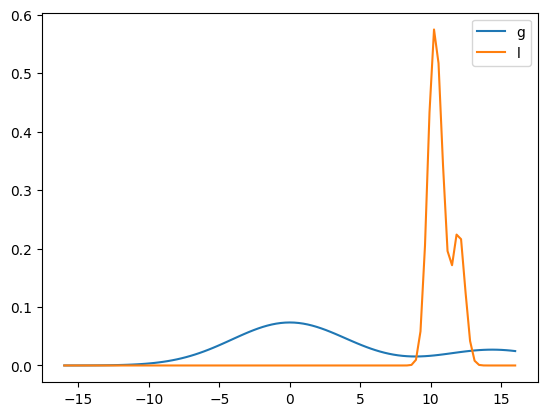

score: -26.610950644421294
best trial is 20
[TRIAL: 0009]##########


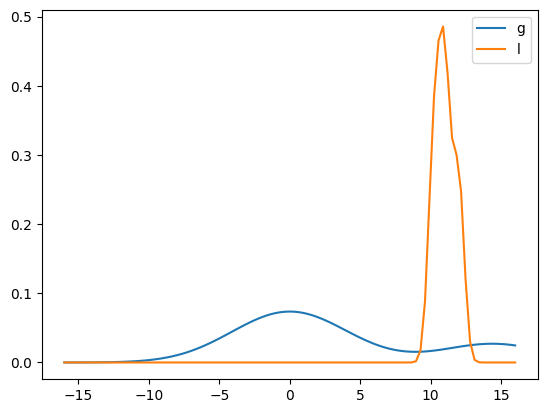

score: -26.813938424109878
best trial is 21
[TRIAL: 0010]##########


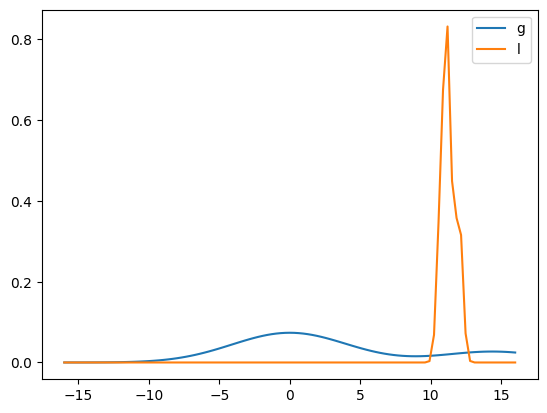

score: -26.243369566351383
best trial is 21
[TRIAL: 0011]##########


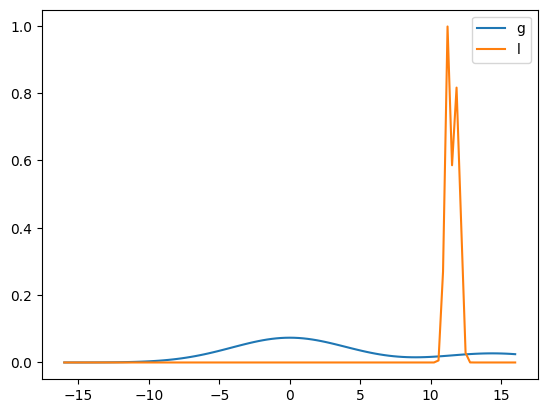

score: -23.425578132259805
best trial is 21
[TRIAL: 0012]##########


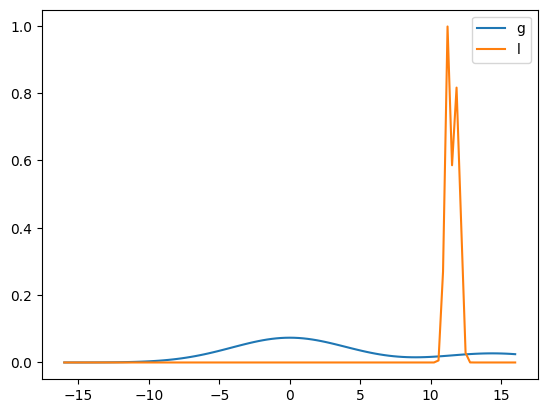

score: -27.17750185048782
best trial is 24
[TRIAL: 0013]##########


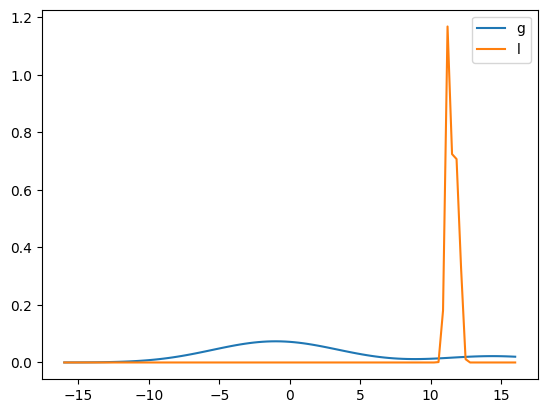

score: -25.845650077504434
best trial is 24
[TRIAL: 0014]##########


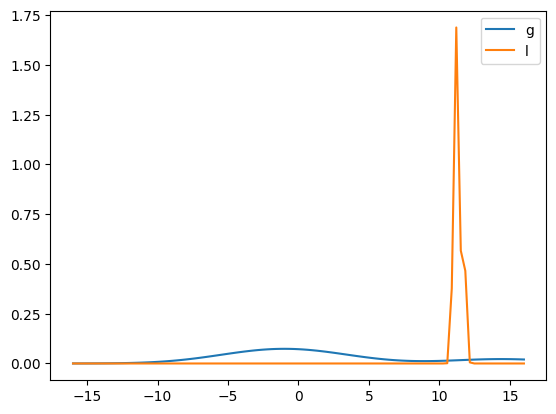

score: -27.178907556151845
best trial is 26
[TRIAL: 0015]##########


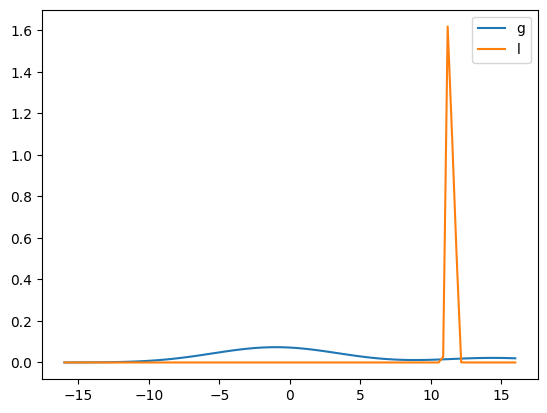

score: -17.428807605210856
best trial is 26
[TRIAL: 0016]##########


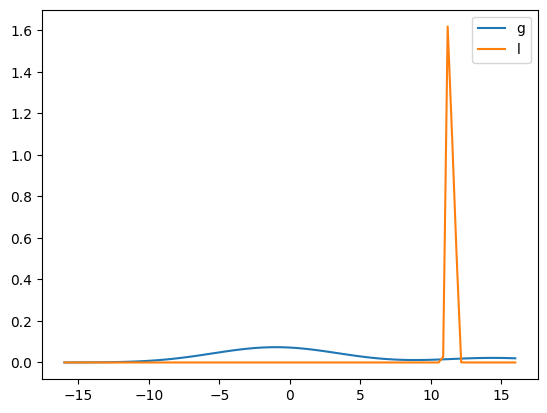

score: -25.939870983514975
best trial is 26
[TRIAL: 0017]##########


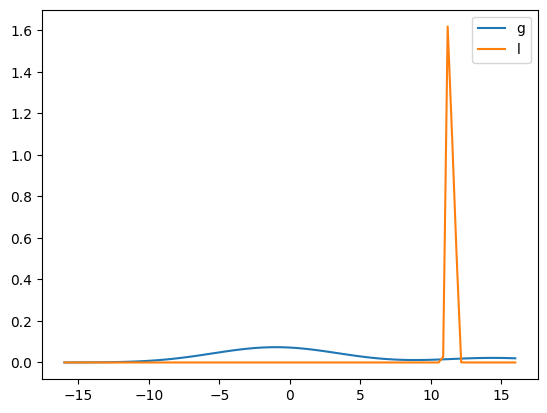

score: -1.9368854022363575
best trial is 26
[TRIAL: 0018]##########


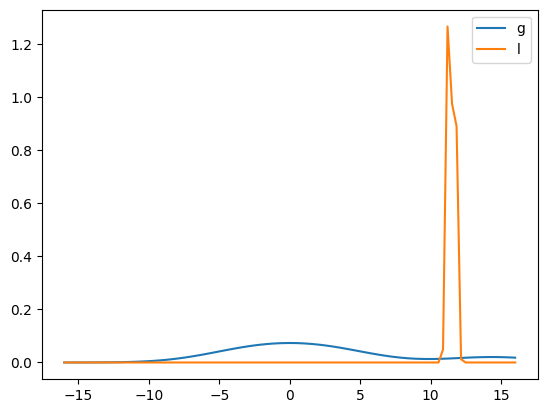

score: -26.67116896456326
best trial is 26
[TRIAL: 0019]##########


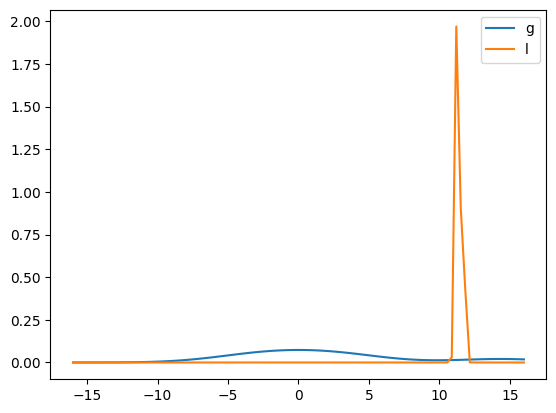

score: -26.927649247425272
best trial is 26
[TRIAL: 0020]##########


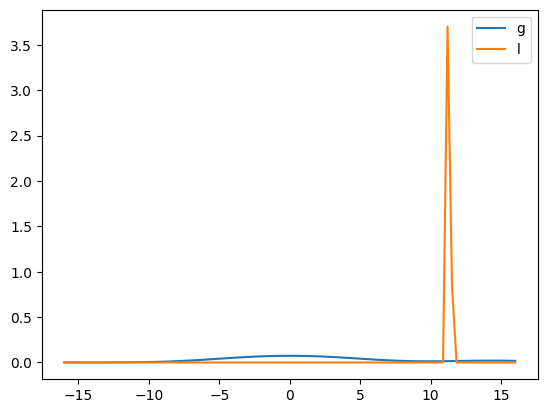

score: -26.92994179276371
best trial is 26
[TRIAL: 0021]##########


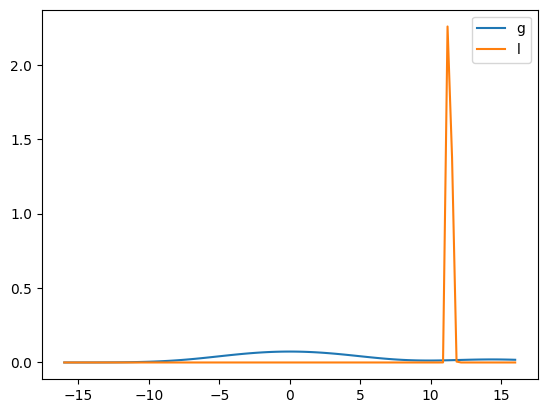

score: -24.527979970734098
best trial is 26
[TRIAL: 0022]##########


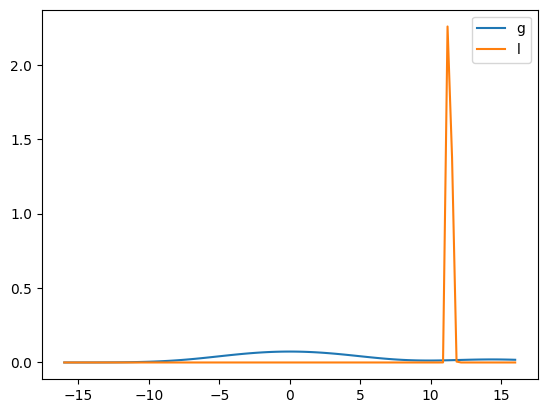

score: -3.3832378460902217
best trial is 26
[TRIAL: 0023]##########


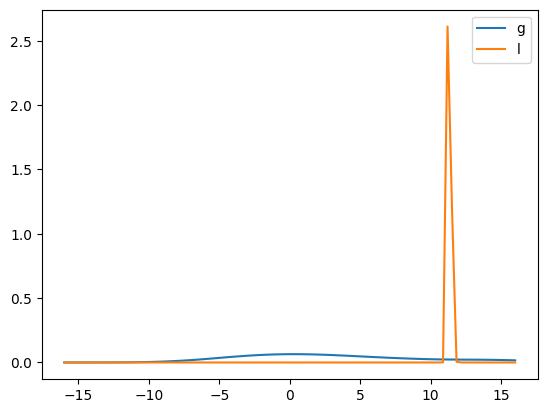

score: -26.58383425420579
best trial is 26
[TRIAL: 0024]##########


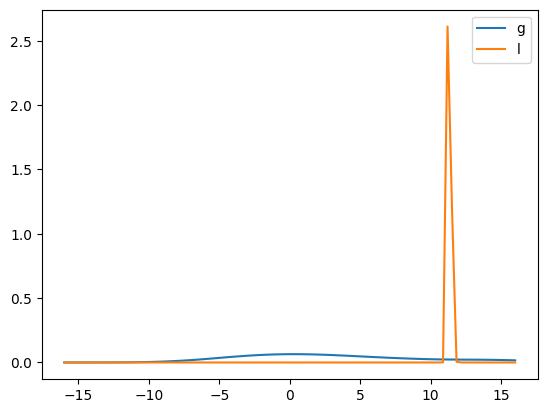

score: -2.7311838935516635
best trial is 26
[TRIAL: 0025]##########


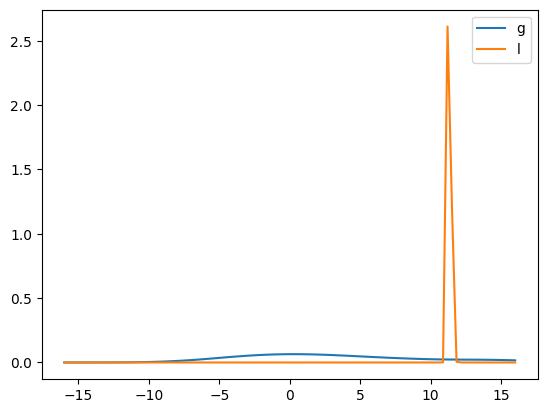

score: -25.068593259301682
best trial is 26
[TRIAL: 0026]##########


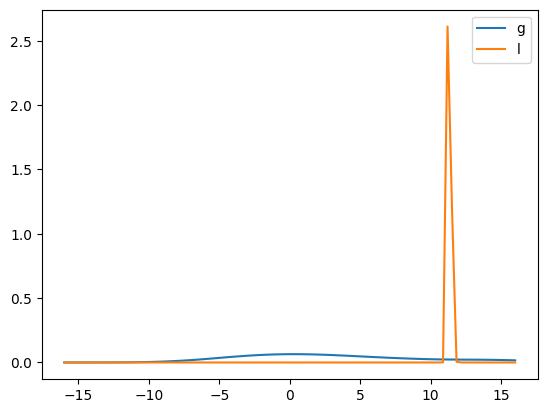

score: -26.152113007928033
best trial is 26
[TRIAL: 0027]##########


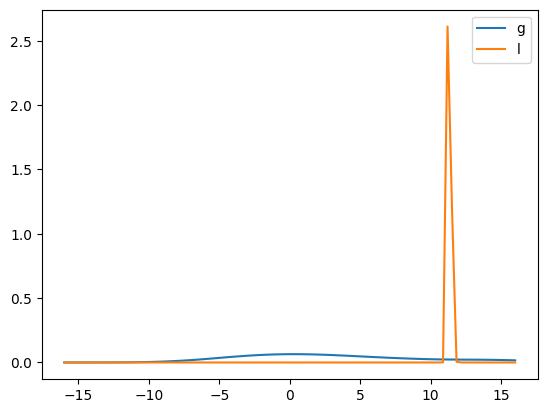

score: -24.9571938473746
best trial is 26
[TRIAL: 0028]##########


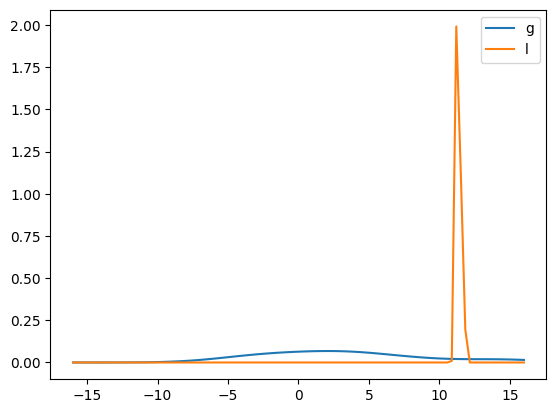

score: -25.56894314876359
best trial is 26
[TRIAL: 0029]##########


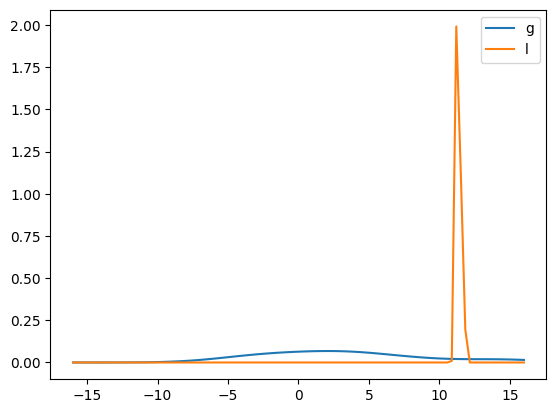

score: -27.02747549548806
best trial is 26
[TRIAL: 0030]##########


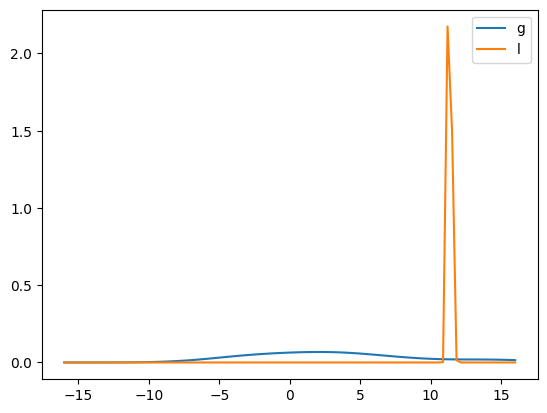

score: -27.143635833309176
best trial is 26
[TRIAL: 0031]##########


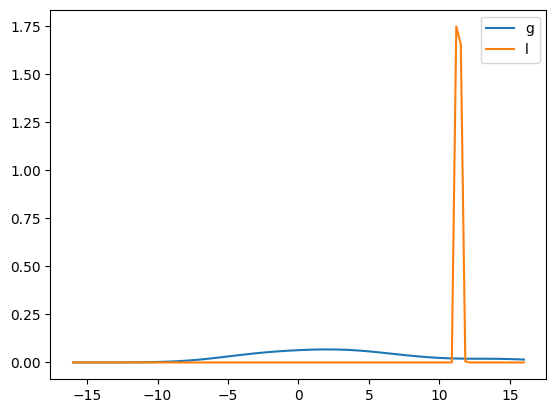

score: -26.002230843206124
best trial is 26
[TRIAL: 0032]##########


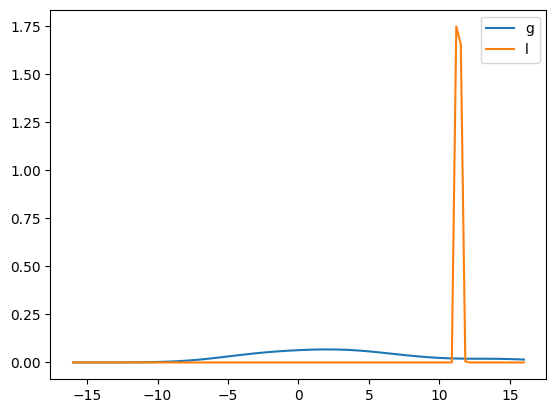

score: -24.350039864164774
best trial is 26
[TRIAL: 0033]##########


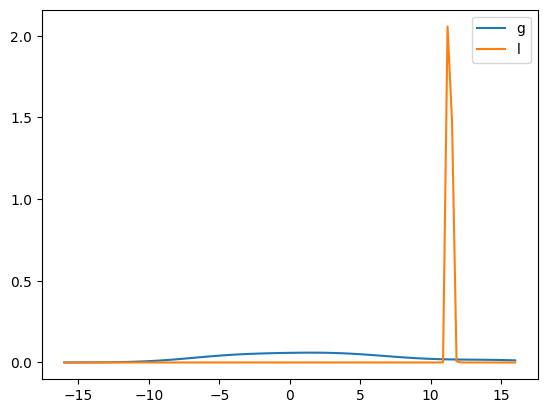

score: -42.56887263279867
best trial is 45
[TRIAL: 0034]##########


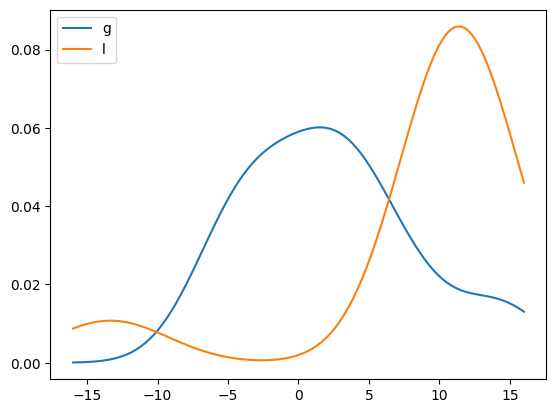

score: -60.72961822269783
best trial is 46
[TRIAL: 0035]##########


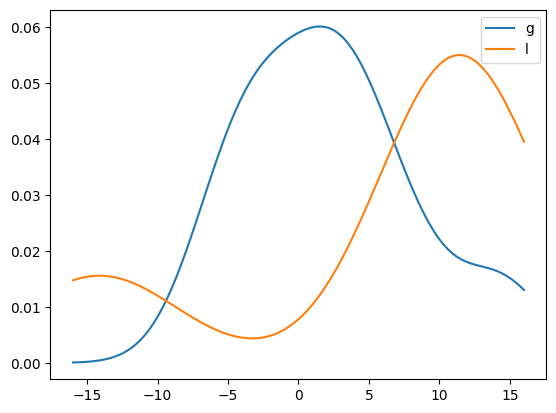

score: -47.82958656184866
best trial is 46
[TRIAL: 0036]##########


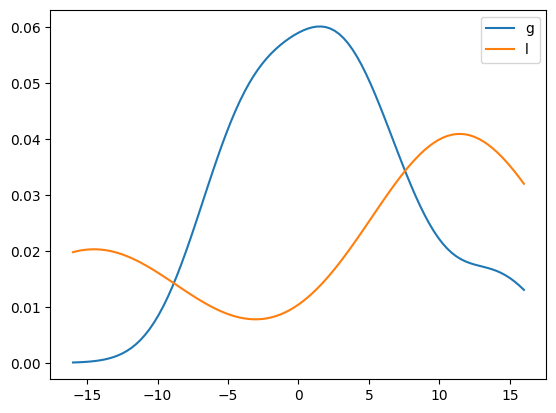

score: -43.028281767834955
best trial is 46
[TRIAL: 0037]##########


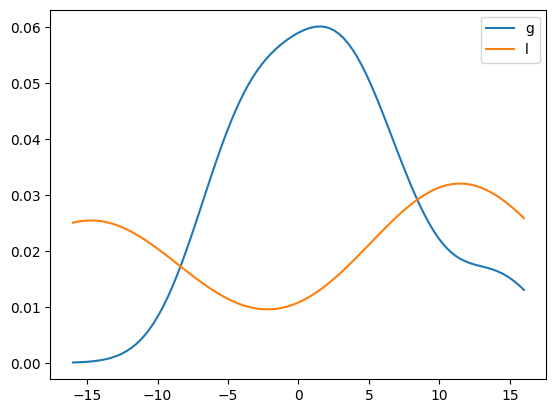

score: -62.80436591804021
best trial is 49
[TRIAL: 0038]##########


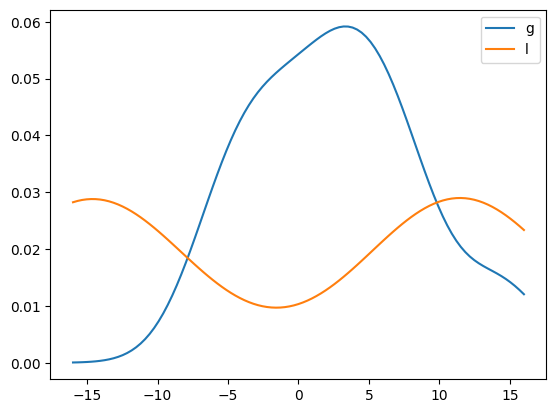

score: -49.28929800088467
best trial is 49
[TRIAL: 0039]##########


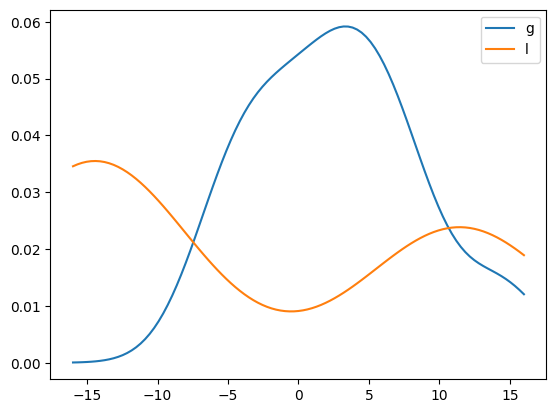

score: -23.359102084030972
best trial is 49
[TRIAL: 0040]##########


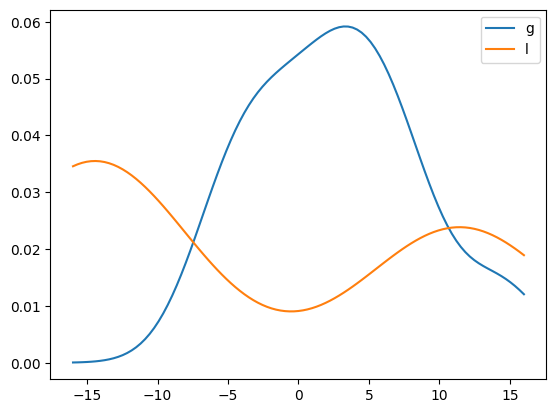

score: -65.29054780066943
best trial is 52
[TRIAL: 0041]##########


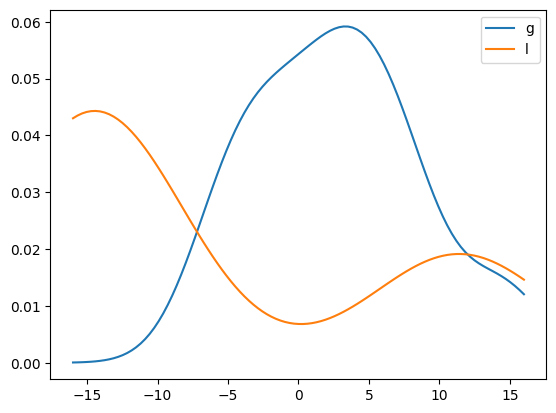

score: -48.99124744989086
best trial is 52
[TRIAL: 0042]##########


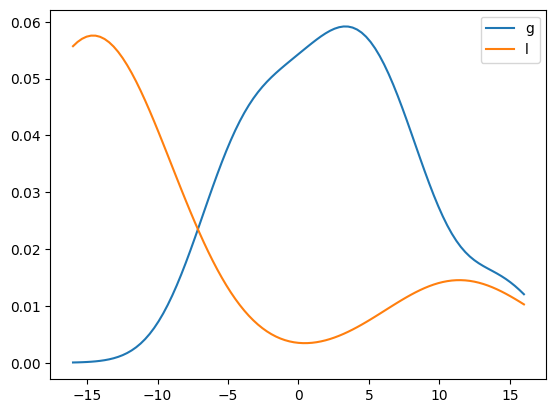

score: -58.608758590408655
best trial is 52
[TRIAL: 0043]##########


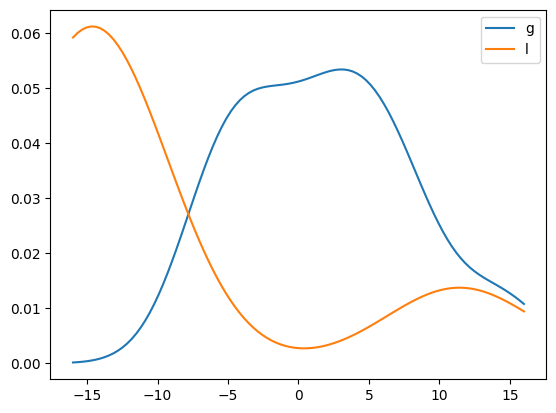

score: -29.6544069506203
best trial is 52
[TRIAL: 0044]##########


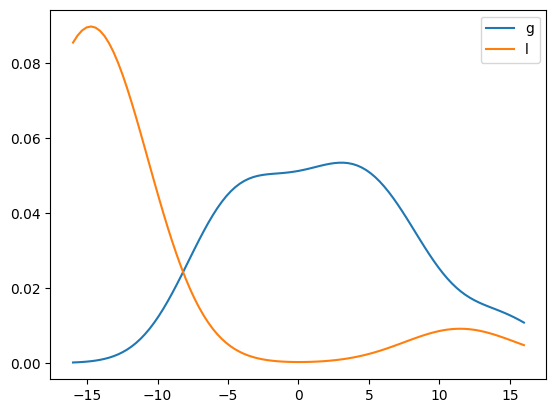

score: -58.931534285904995
best trial is 52
[TRIAL: 0045]##########


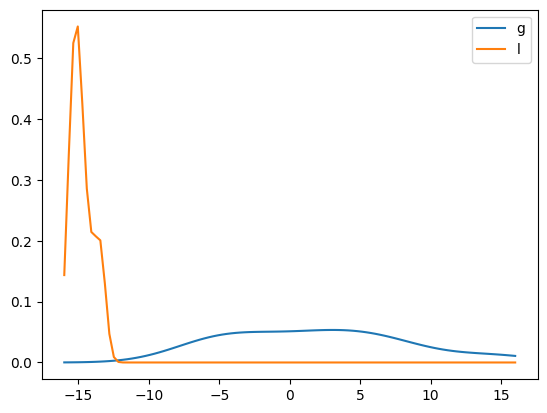

score: -58.158624046782336
best trial is 52
[TRIAL: 0046]##########


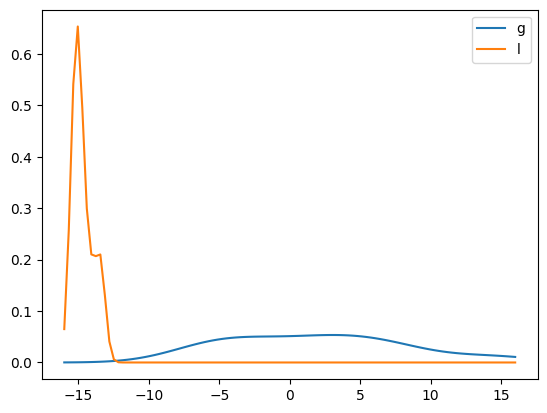

score: -1.8849880827162198
best trial is 52
[TRIAL: 0047]##########


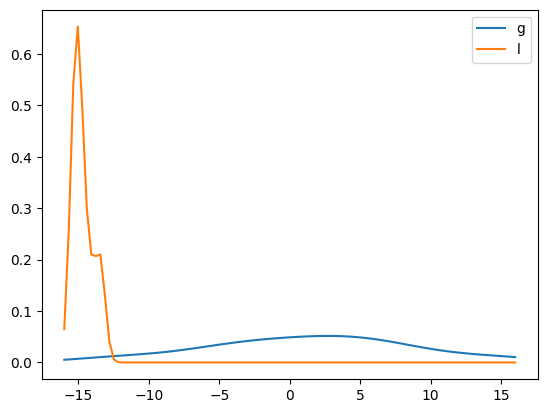

score: -62.415256444211785
best trial is 52
[TRIAL: 0048]##########


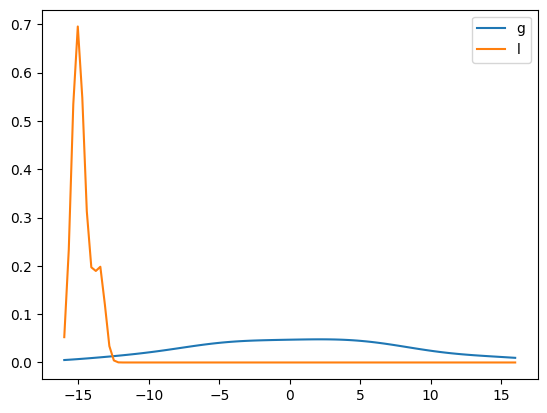

score: -57.57930387877383
best trial is 52
[TRIAL: 0049]##########


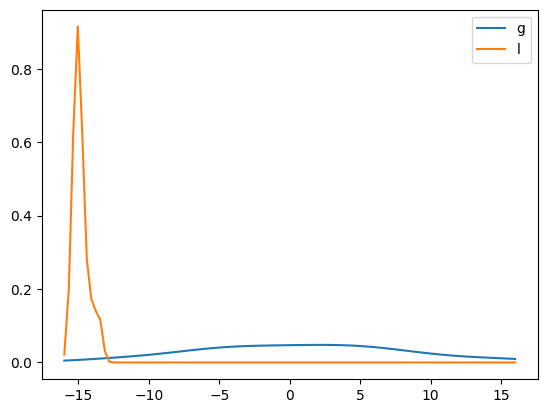

score: -57.934998756922255
best trial is 52
[TRIAL: 0050]##########


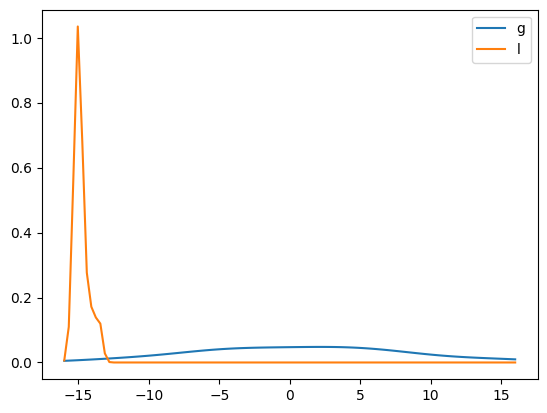

score: -52.01912820493083
best trial is 52
[TRIAL: 0051]##########


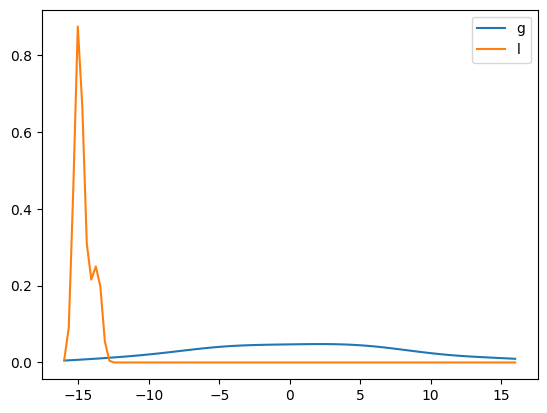

score: -53.19423553355049
best trial is 52
[TRIAL: 0052]##########


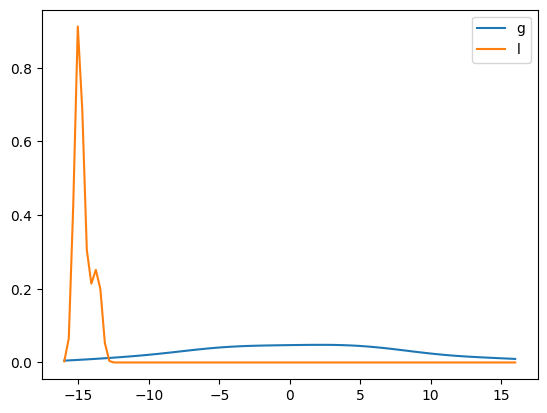

score: -64.90369008609244
best trial is 52
[TRIAL: 0053]##########


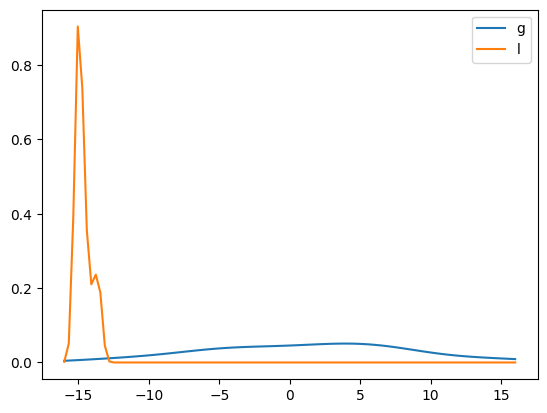

score: -50.863676684422295
best trial is 52
[TRIAL: 0054]##########


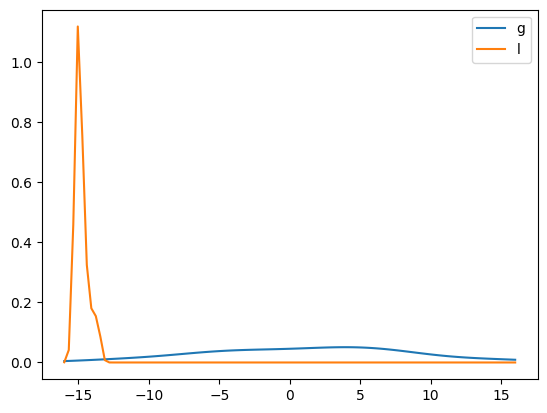

score: -56.67545141316341
best trial is 52
[TRIAL: 0055]##########


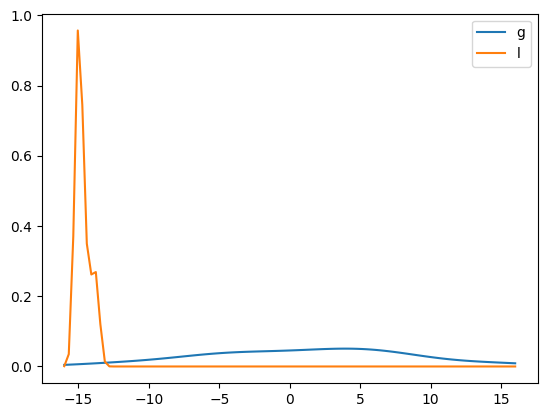

score: -61.71594319219095
best trial is 52
[TRIAL: 0056]##########


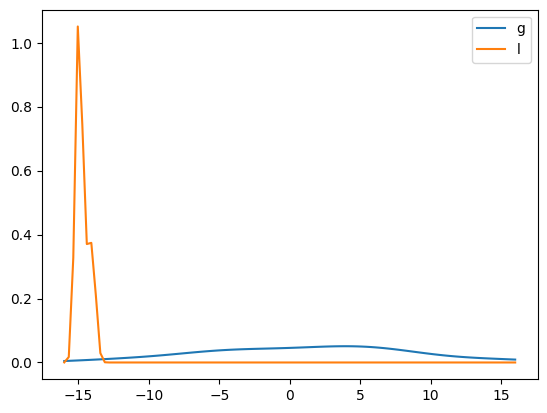

score: -62.104287093444086
best trial is 52
[TRIAL: 0057]##########


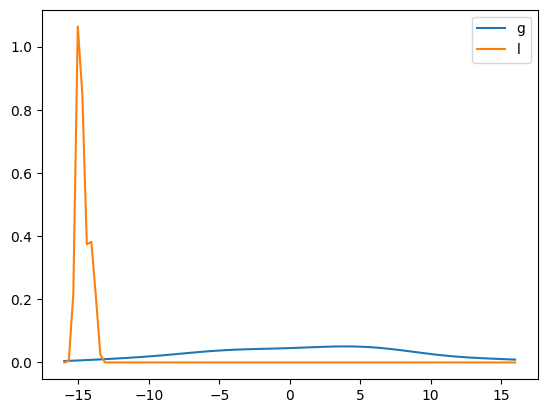

score: -53.447155716509386
best trial is 52
[TRIAL: 0058]##########


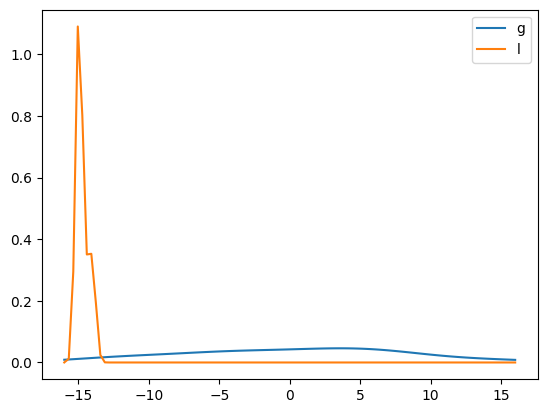

score: -62.714443338365385
best trial is 52
[TRIAL: 0059]##########


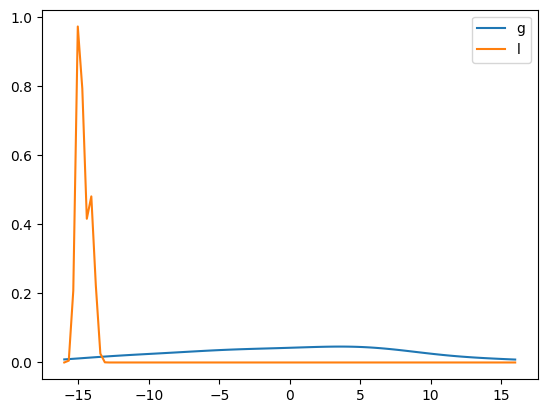

score: -44.920974752187654
best trial is 52
[TRIAL: 0060]##########


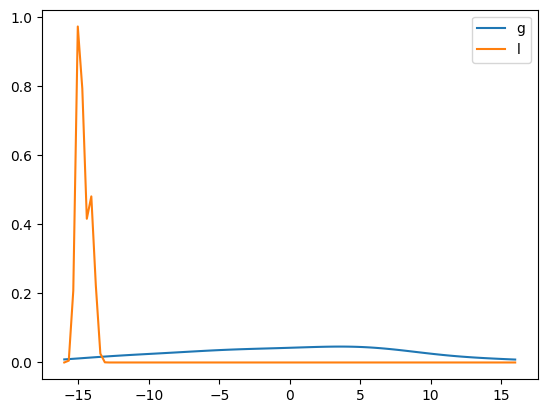

score: -63.26020403392303
best trial is 52
[TRIAL: 0061]##########


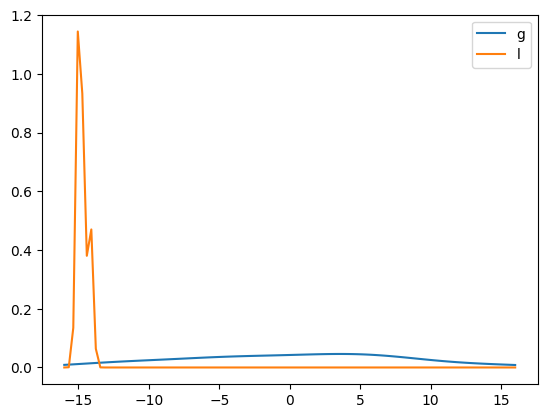

score: -64.61621543863039
best trial is 52
[TRIAL: 0062]##########


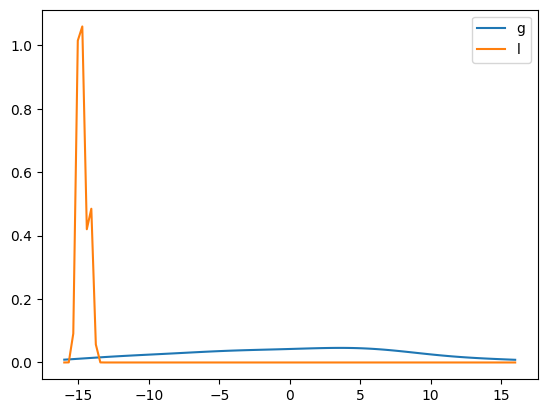

score: -1.1660364108818253
best trial is 52
[TRIAL: 0063]##########


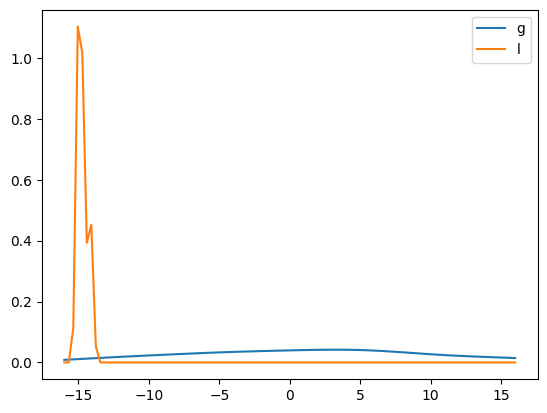

score: -64.90020550942577
best trial is 52
[TRIAL: 0064]##########


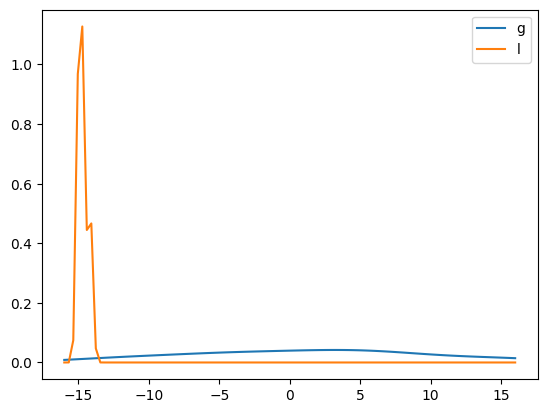

score: -61.66847600504235
best trial is 52
[TRIAL: 0065]##########


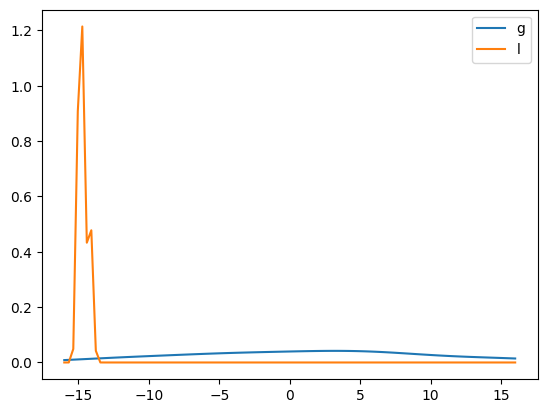

score: -62.460165285093545
best trial is 52
[TRIAL: 0066]##########


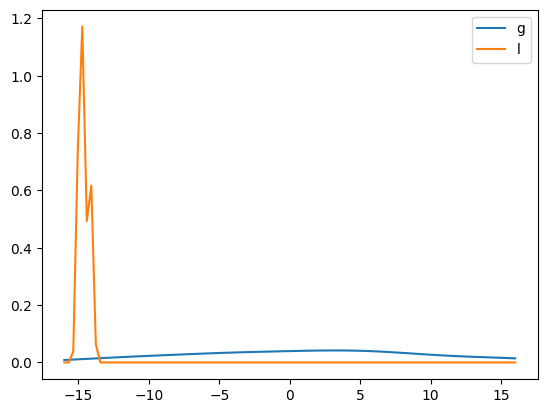

score: -53.80918074698301
best trial is 52
[TRIAL: 0067]##########


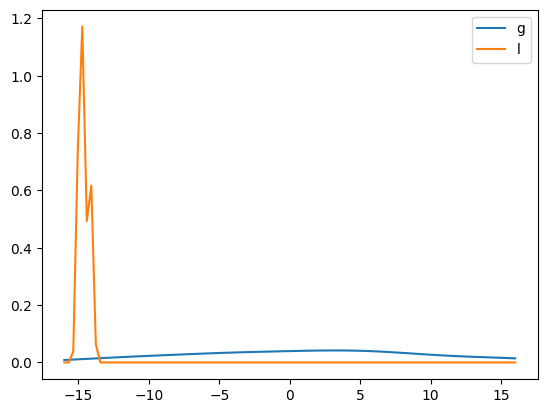

score: -63.14532752443327
best trial is 52
[TRIAL: 0068]##########


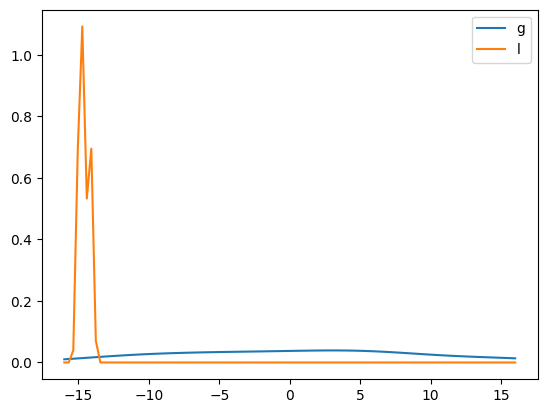

score: -60.55245934804109
best trial is 52
[TRIAL: 0069]##########


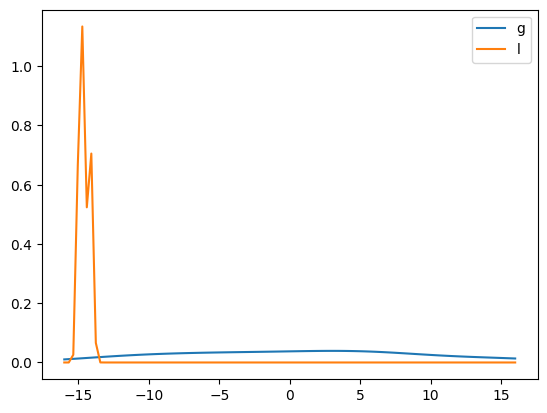

score: -64.83329059898311
best trial is 52
[TRIAL: 0070]##########


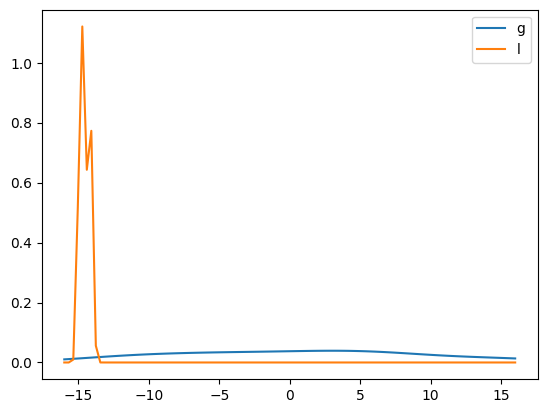

score: -54.844756699485586
best trial is 52
[TRIAL: 0071]##########


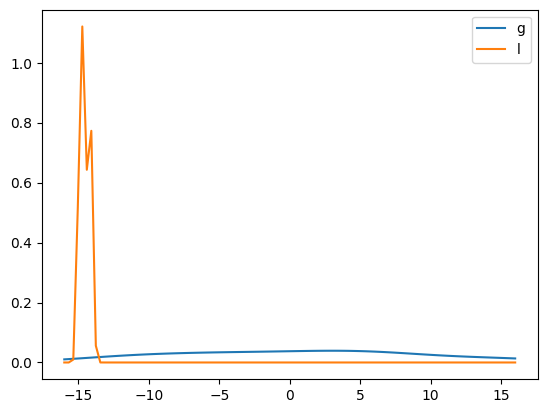

score: -41.81731925254374
best trial is 52
[TRIAL: 0072]##########


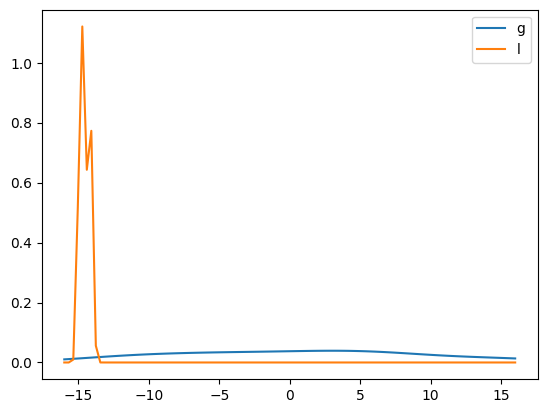

score: -46.00124571216698
best trial is 52
[TRIAL: 0073]##########


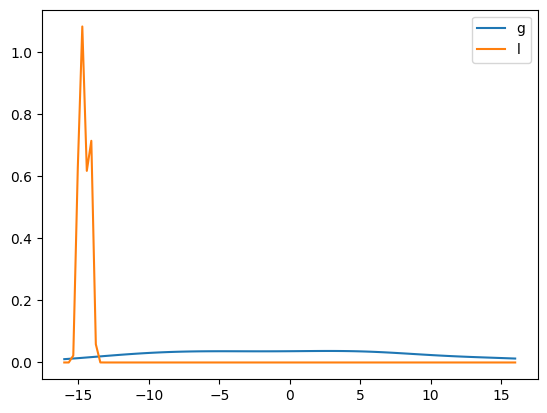

score: -60.193670405793505
best trial is 52
[TRIAL: 0074]##########


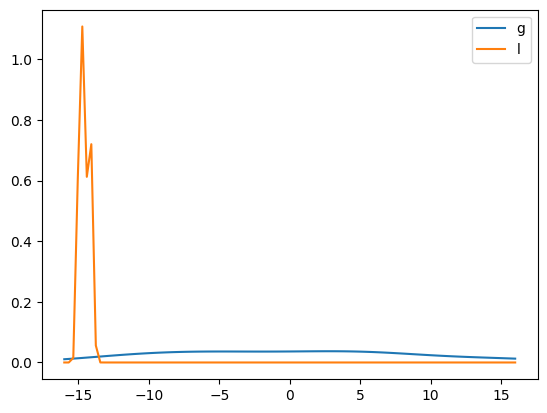

score: -64.6273667200126
best trial is 52
[TRIAL: 0075]##########


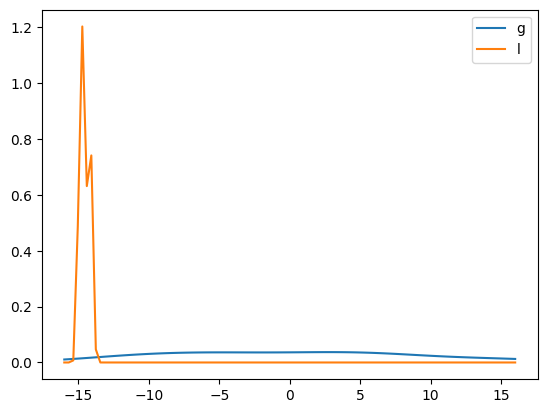

score: -61.248148724920625
best trial is 52
[TRIAL: 0076]##########


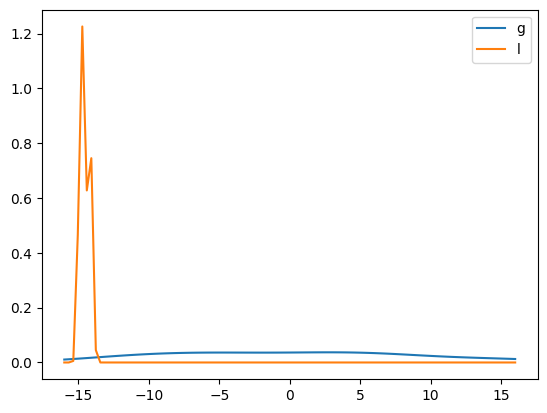

score: -54.02736564212286
best trial is 52
[TRIAL: 0077]##########


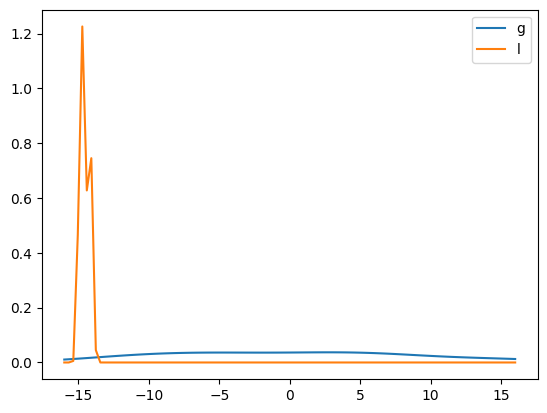

score: -62.457140412802524
best trial is 52
[TRIAL: 0078]##########


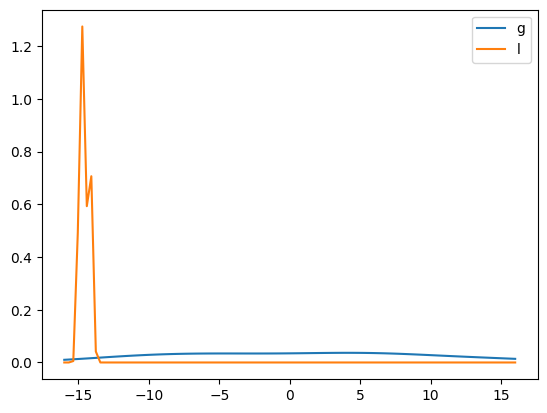

score: -61.975856330645584
best trial is 52
[TRIAL: 0079]##########


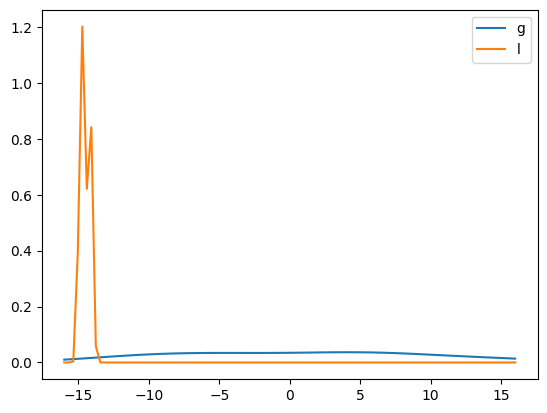

score: -65.00829224850068
best trial is 52
[TRIAL: 0080]##########


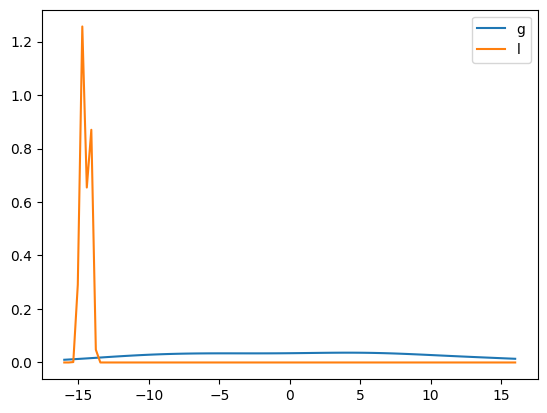

score: -53.01559280053216
best trial is 52
[TRIAL: 0081]##########


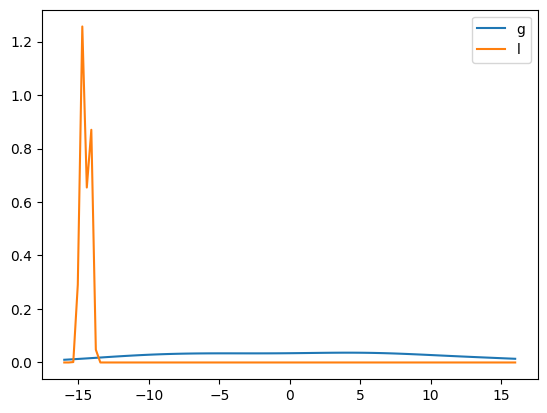

score: -63.56565327936737
best trial is 52
[TRIAL: 0082]##########


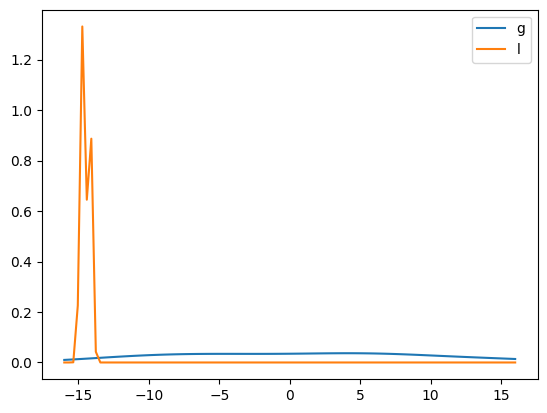

score: -62.95135645518342
best trial is 52
[TRIAL: 0083]##########


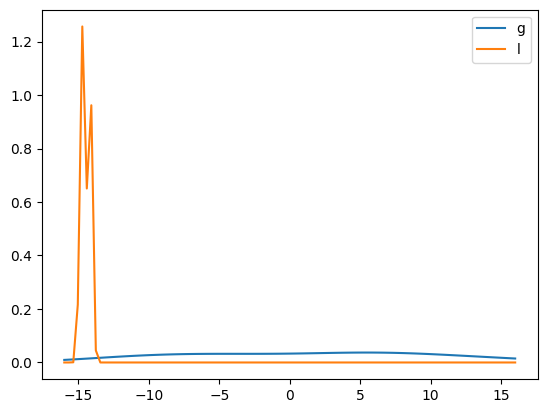

score: -63.749694112591975
best trial is 52
[TRIAL: 0084]##########


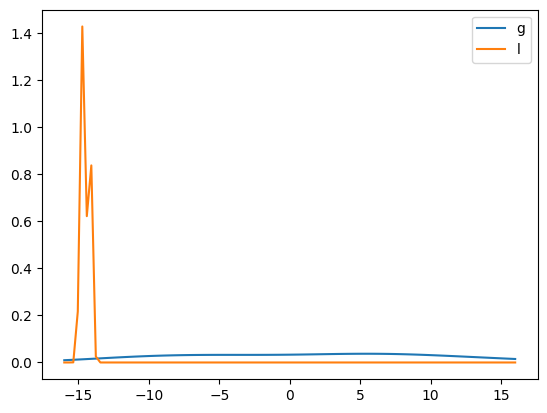

score: -60.337882318766724
best trial is 52
[TRIAL: 0085]##########


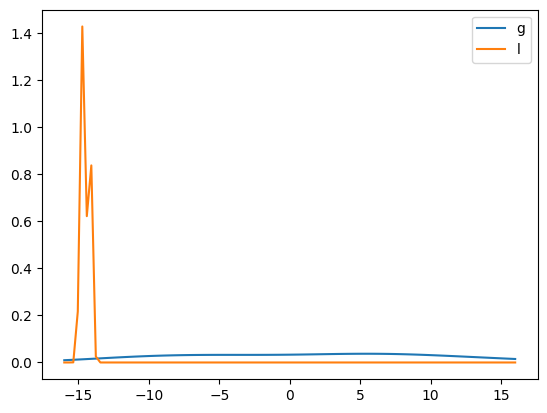

score: -57.91549734058547
best trial is 52
[TRIAL: 0086]##########


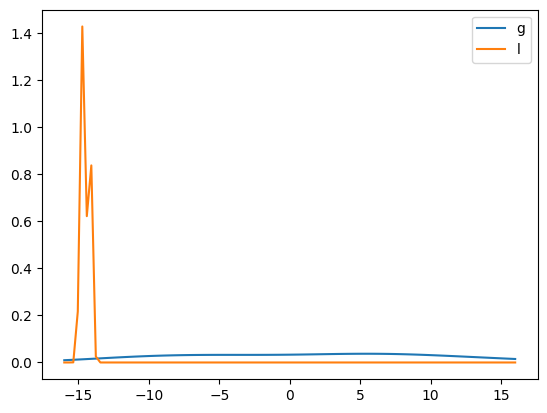

score: -65.07299169593338
best trial is 52
[TRIAL: 0087]##########


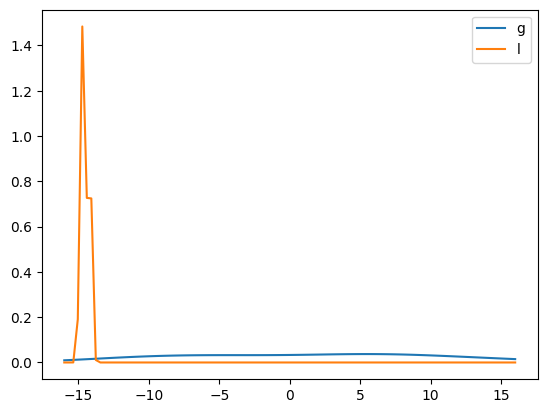

score: -65.2659279923166
best trial is 52
[TRIAL: 0088]##########


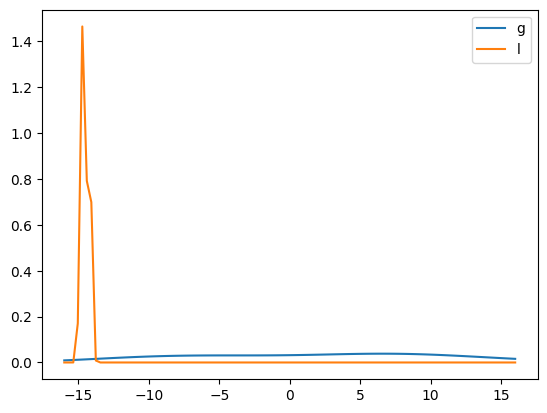

score: -24.39672065358694
best trial is 52
[TRIAL: 0089]##########


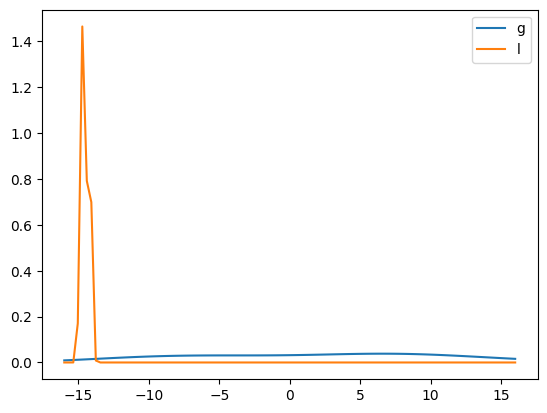

score: -65.31019019563337
best trial is 101
[TRIAL: 0090]##########


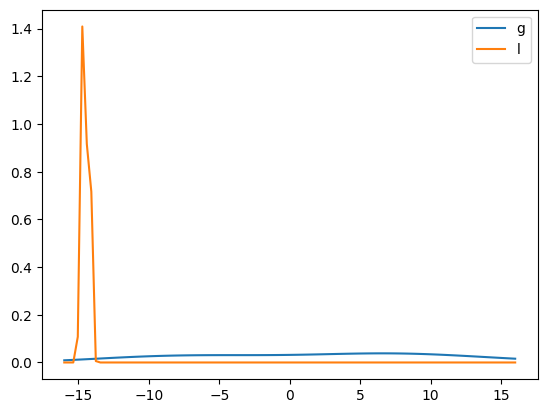

score: -62.70225771279114
best trial is 101
[TRIAL: 0091]##########


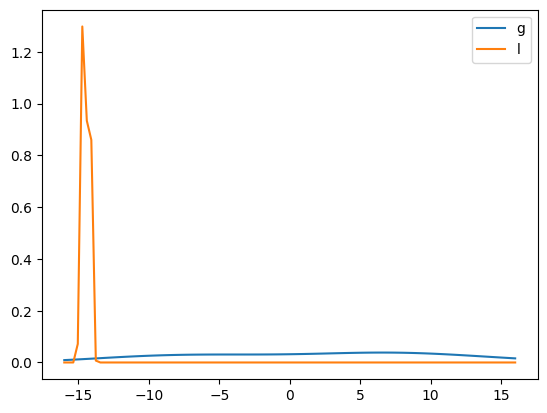

score: -58.15310837253118
best trial is 101
[TRIAL: 0092]##########


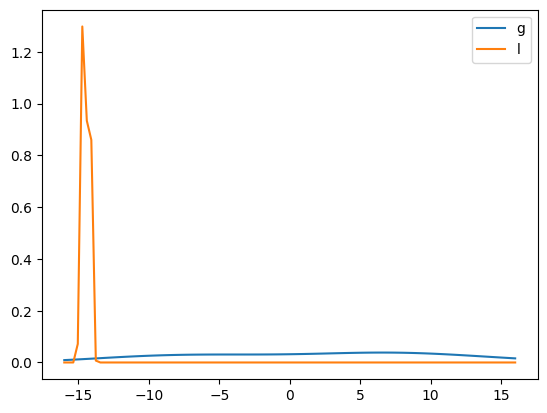

score: -62.875827248188905
best trial is 101
[TRIAL: 0093]##########


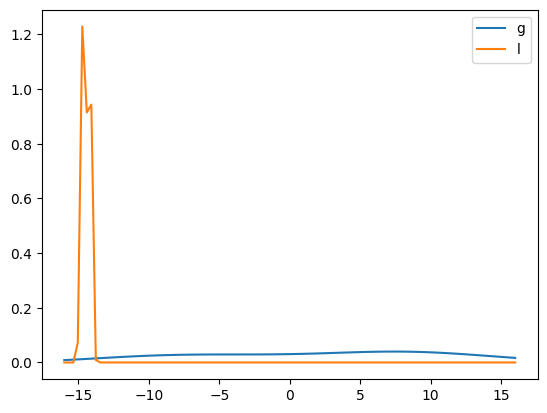

score: -64.99015520776405
best trial is 101
[TRIAL: 0094]##########


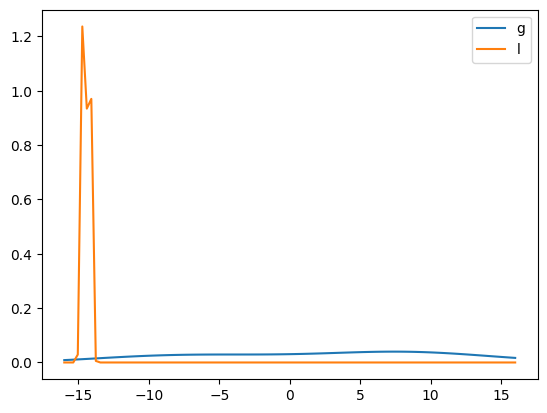

score: -52.08099637197609
best trial is 101
[TRIAL: 0095]##########


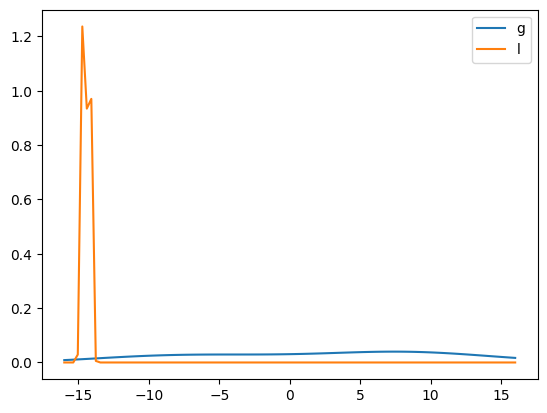

score: -65.18871267725824
best trial is 101
[TRIAL: 0096]##########


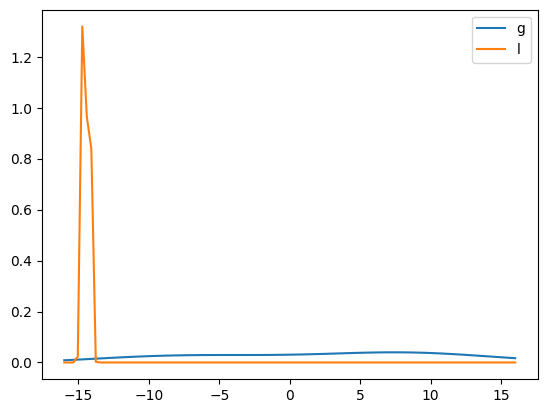

score: -63.504304812436054
best trial is 101
[TRIAL: 0097]##########


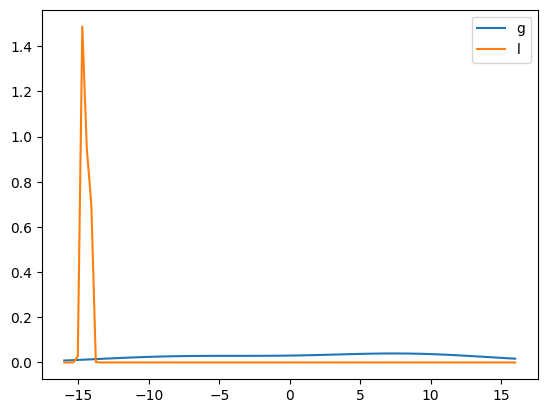

score: -62.86023066120565
best trial is 101
[TRIAL: 0098]##########


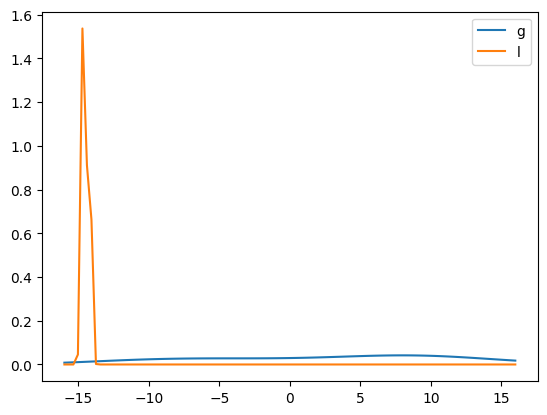

score: -64.68543199587705
best trial is 101
[TRIAL: 0099]##########


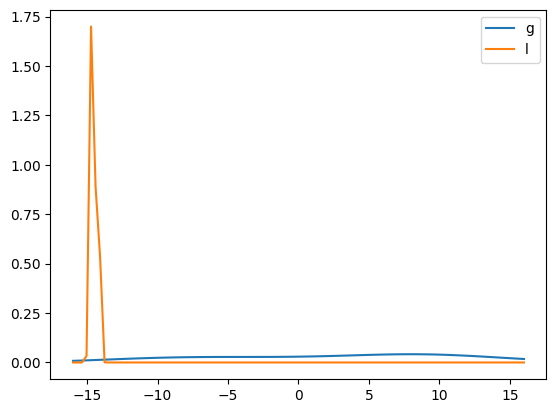

score: -8.997335611112696
best trial is 101
[TRIAL: 0100]##########


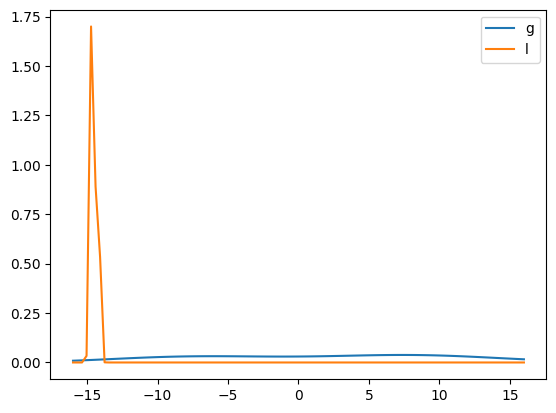

score: -64.92309689138625
best trial is 101
[TRIAL: 0101]##########


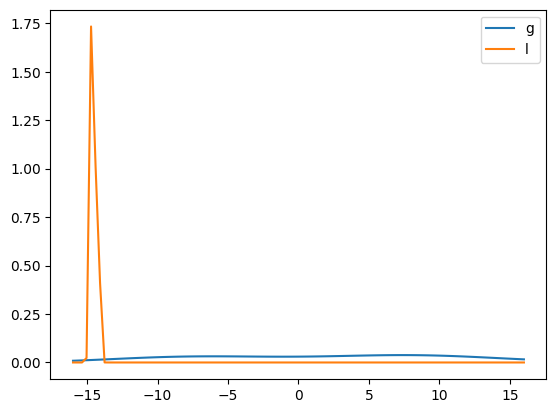

score: -64.877047406025
best trial is 101
[TRIAL: 0102]##########


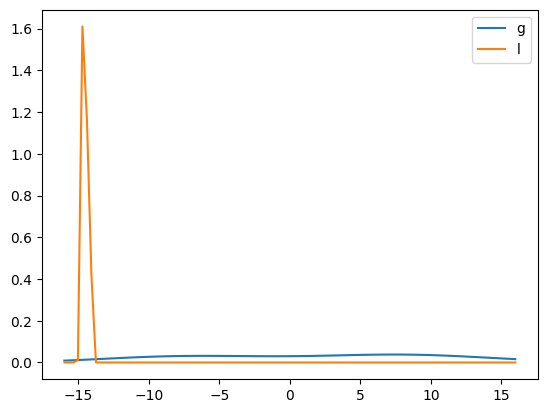

score: -56.81012021049566
best trial is 101
[TRIAL: 0103]##########


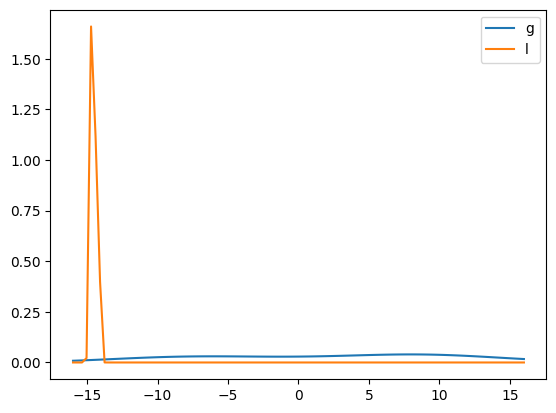

score: -4.860771630846683
best trial is 101
[TRIAL: 0104]##########


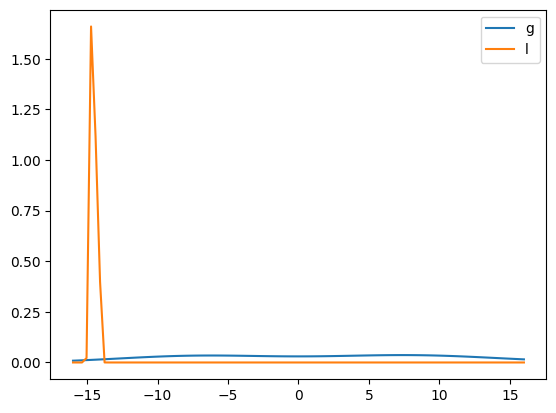

score: -0.32830542892290326
best trial is 101
[TRIAL: 0105]##########


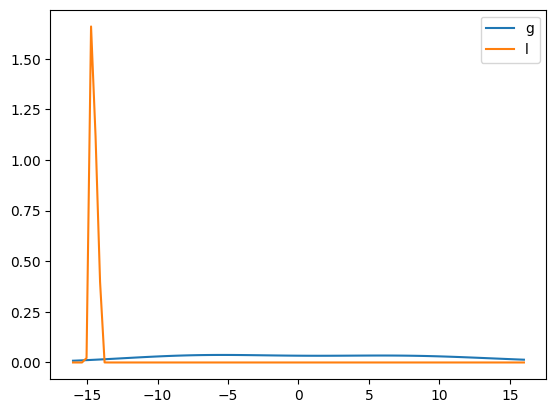

score: -60.26140595739516
best trial is 101
[TRIAL: 0106]##########


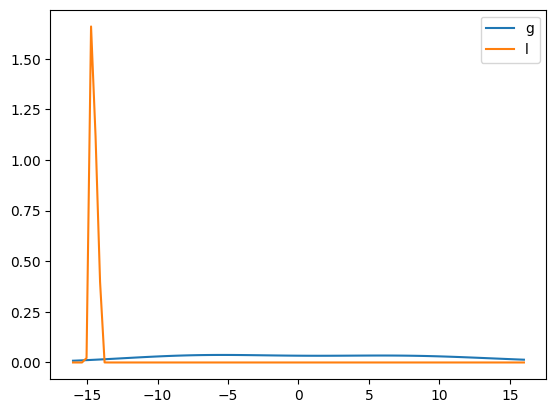

score: -63.582015100017664
best trial is 101
[TRIAL: 0107]##########


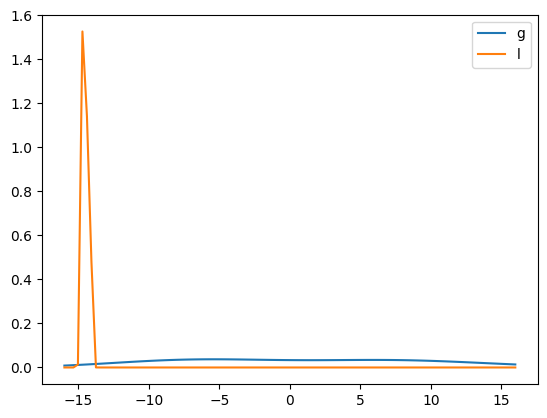

score: -14.991512508829011
best trial is 101
[TRIAL: 0108]##########


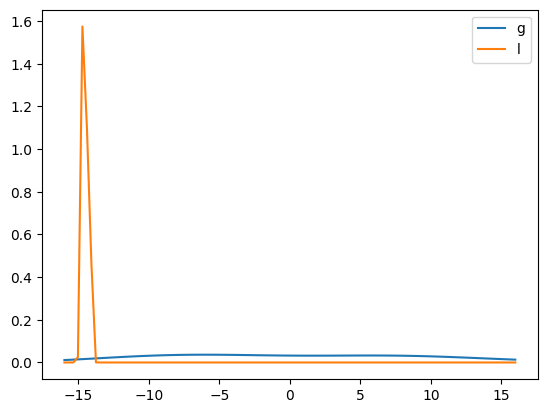

score: -62.91687043874521
best trial is 101
[TRIAL: 0109]##########


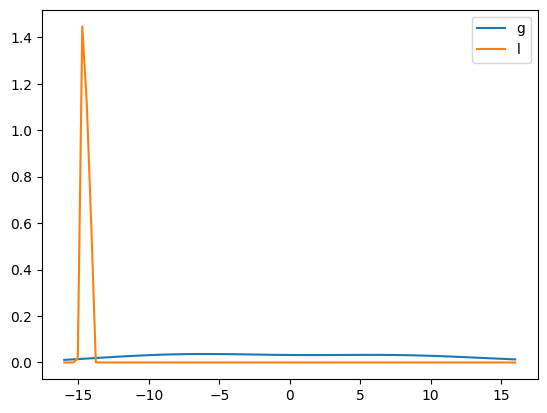

score: -55.60896276068923
best trial is 101
[TRIAL: 0110]##########


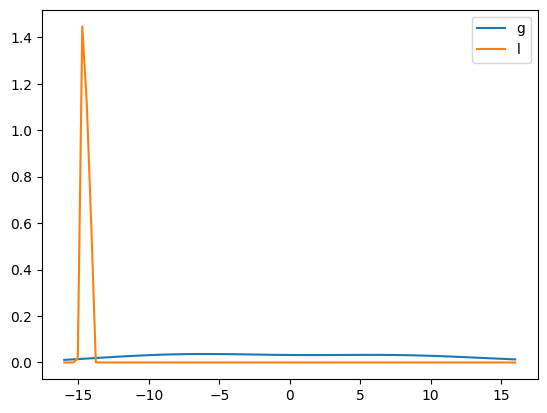

score: -57.493285768939344
best trial is 101
[TRIAL: 0111]##########


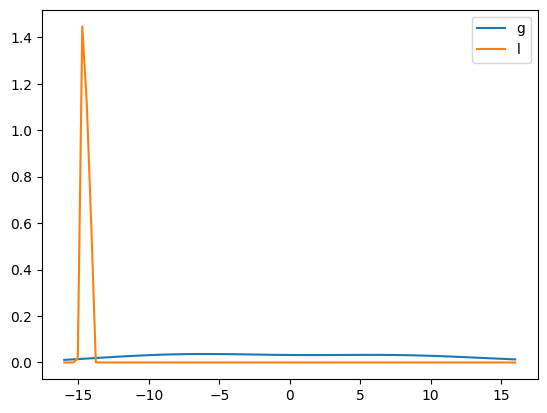

score: -57.54830077133923
best trial is 101
[TRIAL: 0112]##########


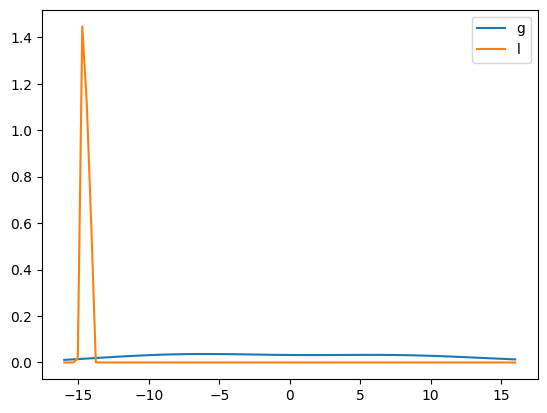

score: -48.40246053542442
best trial is 101
[TRIAL: 0113]##########


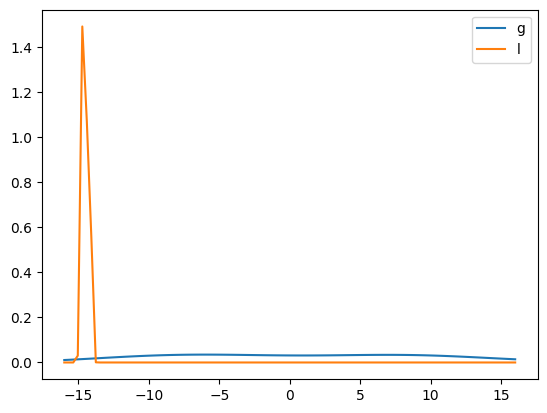

score: -63.54515633603506
best trial is 101
[TRIAL: 0114]##########


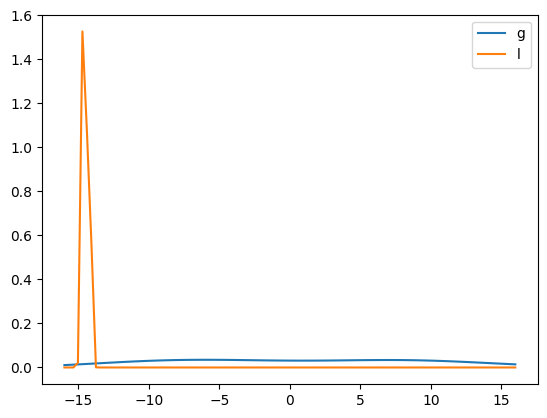

score: -64.11750773358472
best trial is 101
[TRIAL: 0115]##########


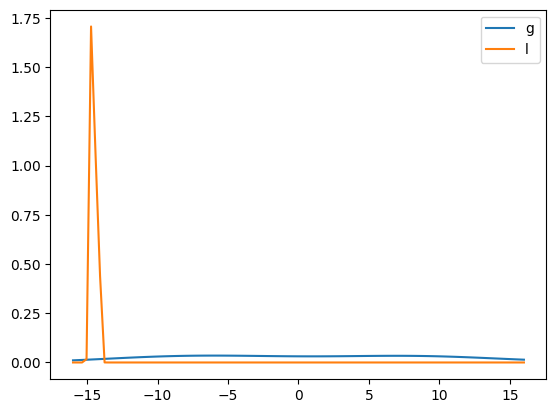

score: -63.57093656386029
best trial is 101
[TRIAL: 0116]##########


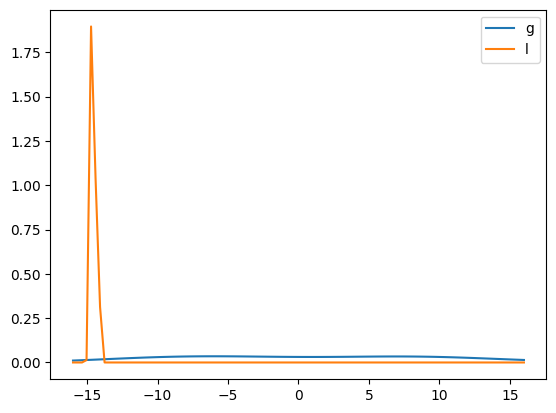

score: -0.20314773797117494
best trial is 101
[TRIAL: 0117]##########


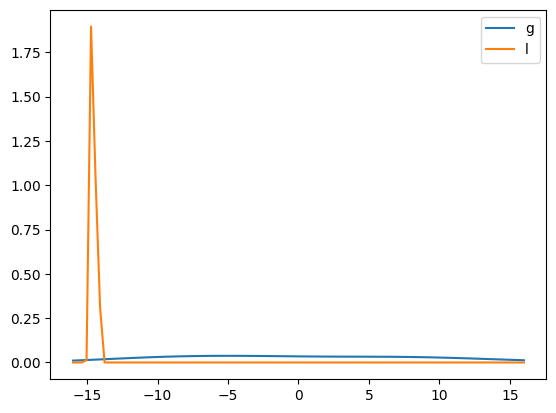

score: -64.8150651220357
best trial is 101
[TRIAL: 0118]##########


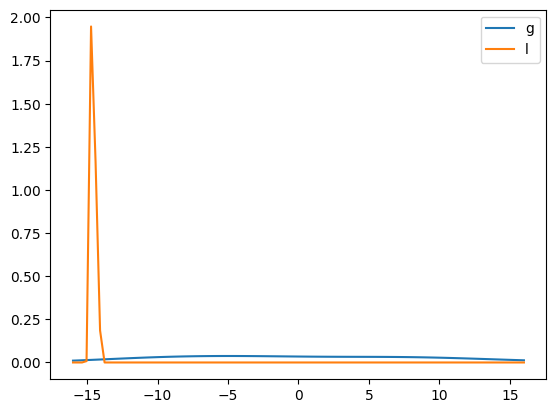

score: -60.260374061431214
best trial is 101
[TRIAL: 0119]##########


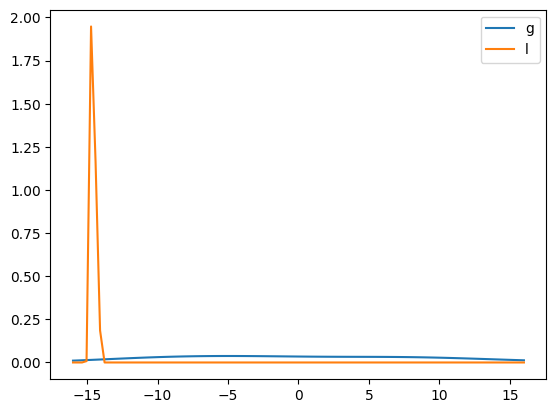

score: -63.18821528014858
best trial is 101
[TRIAL: 0120]##########


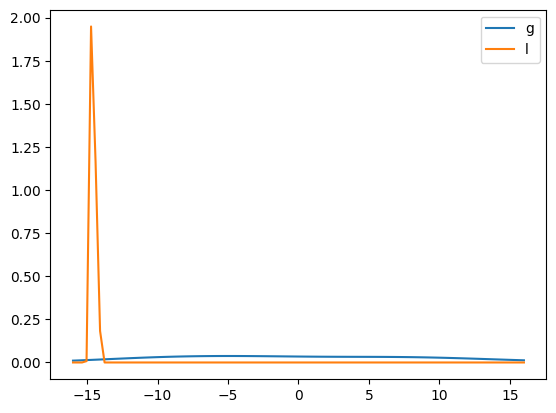

score: -3.3066445202051864
best trial is 101
[TRIAL: 0121]##########


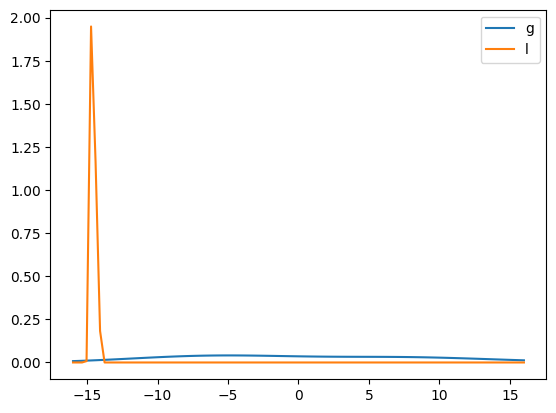

score: 0.7547635523441097
best trial is 101
[TRIAL: 0122]##########


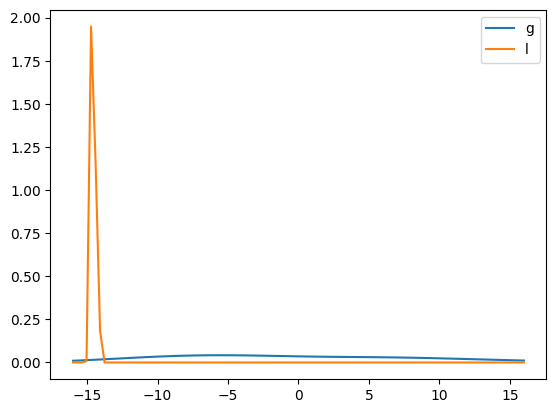

score: -64.02477714369142
best trial is 101
[TRIAL: 0123]##########


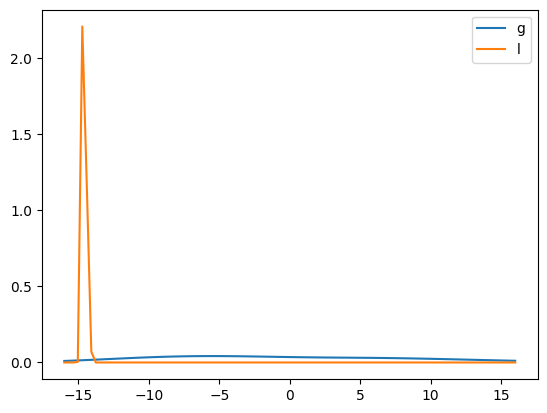

score: -65.17594475206369
best trial is 101
[TRIAL: 0124]##########


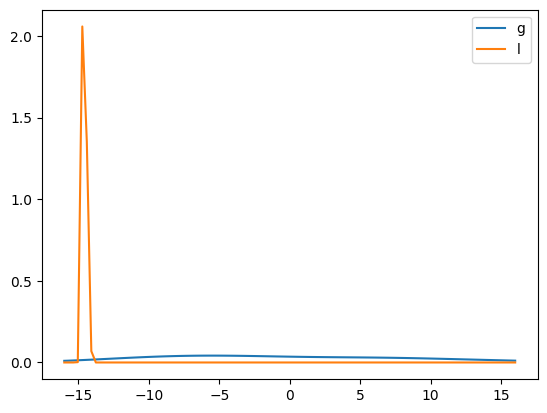

score: -57.70905574829646
best trial is 101
[TRIAL: 0125]##########


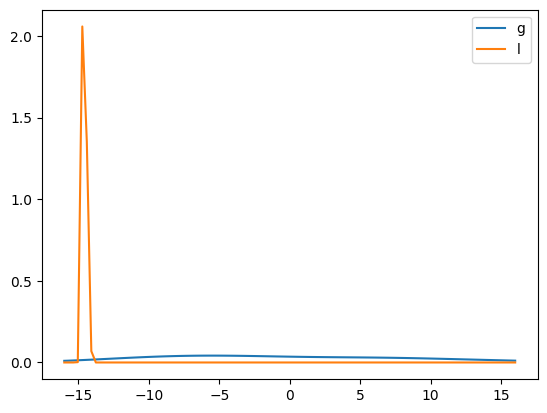

score: -63.77956159880833
best trial is 101
[TRIAL: 0126]##########


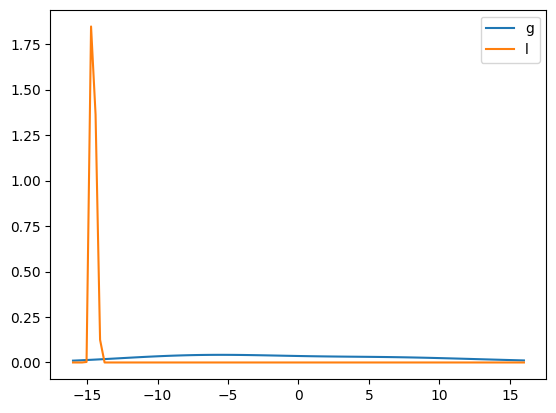

score: -11.808018759394663
best trial is 101
[TRIAL: 0127]##########


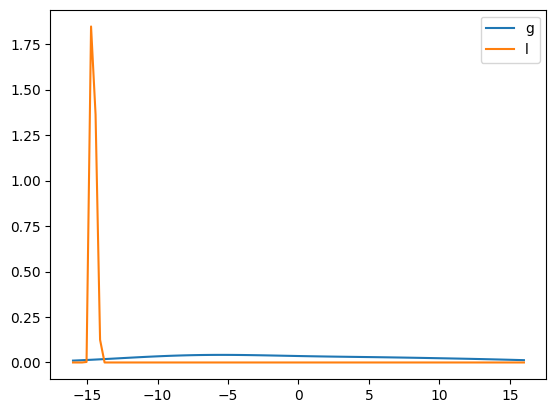

score: -65.1507594277252
best trial is 101
[TRIAL: 0128]##########


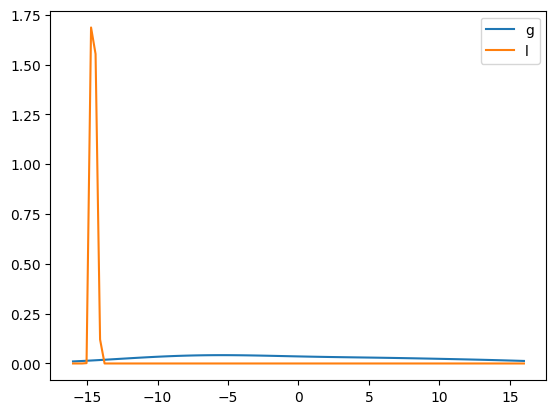

score: -3.89826818034164
best trial is 101
[TRIAL: 0129]##########


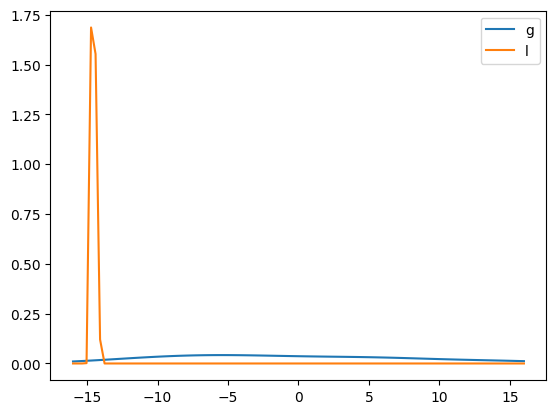

score: -59.79170793301224
best trial is 101
[TRIAL: 0130]##########


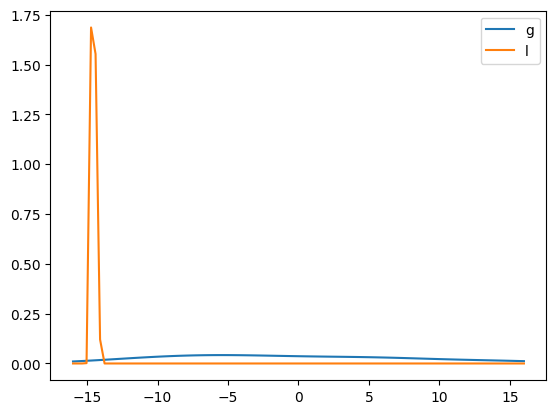

score: -64.5746179987037
best trial is 101
[TRIAL: 0131]##########


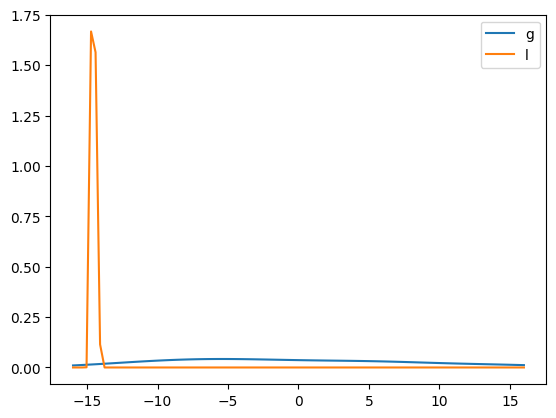

score: -63.65350549016291
best trial is 101
[TRIAL: 0132]##########


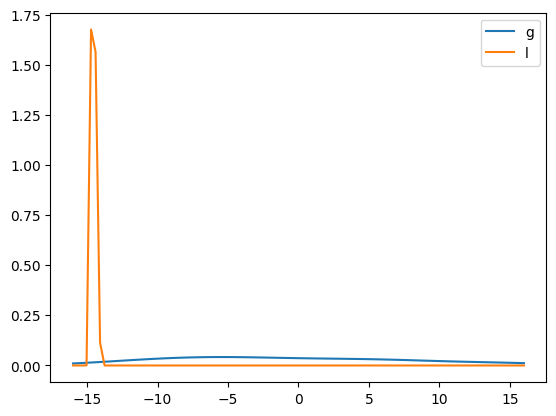

score: -63.701632750522485
best trial is 101
[TRIAL: 0133]##########


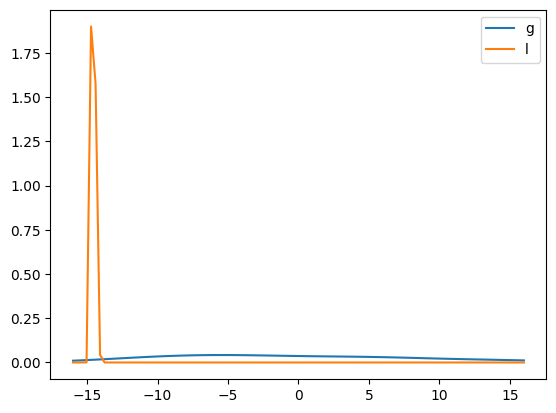

score: -64.00639235975163
best trial is 101
[TRIAL: 0134]##########


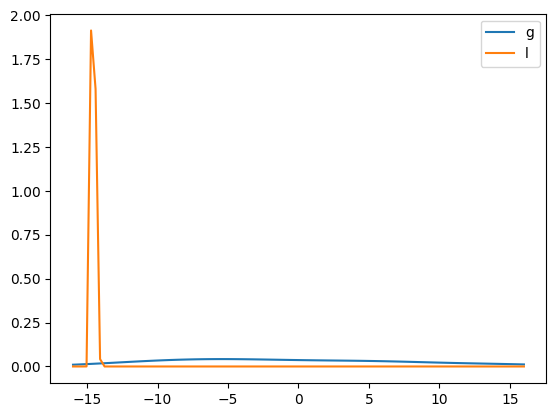

score: -64.96258030969112
best trial is 101
[TRIAL: 0135]##########


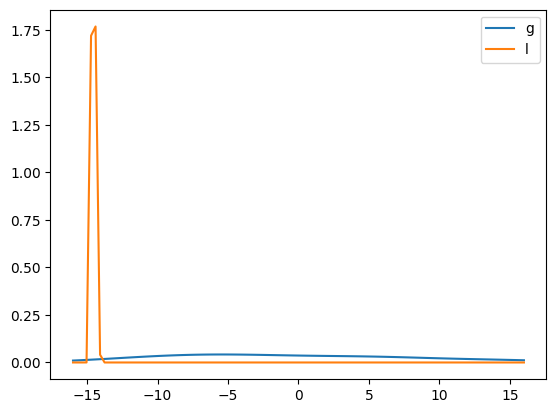

score: -0.8697127451139622
best trial is 101
[TRIAL: 0136]##########


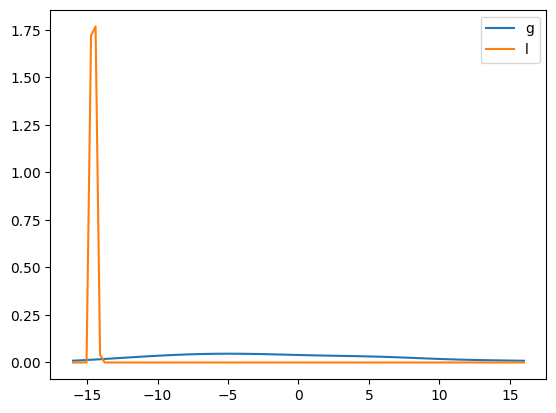

score: -63.96483552874575
best trial is 101
[TRIAL: 0137]##########


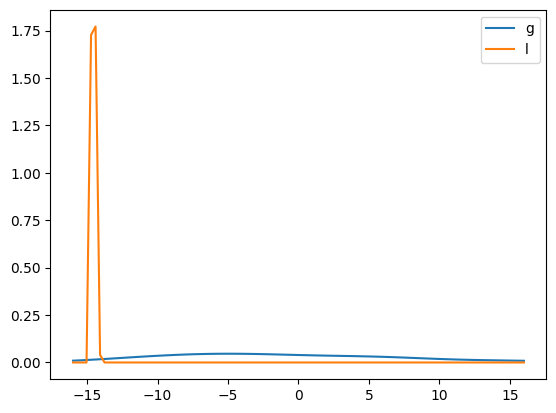

score: -65.15119091651854
best trial is 101
[TRIAL: 0138]##########


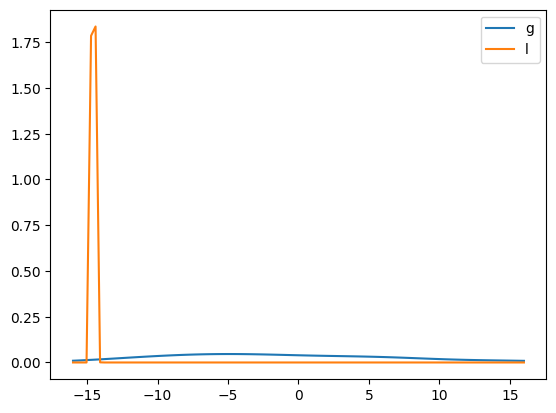

score: -0.5055310023438848
best trial is 101
[TRIAL: 0139]##########


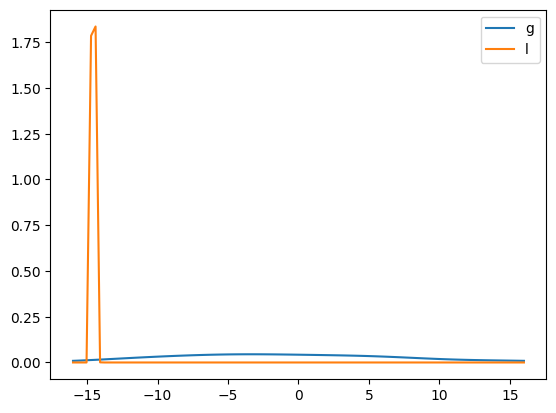

score: -2.0249515910127105
best trial is 101
[TRIAL: 0140]##########


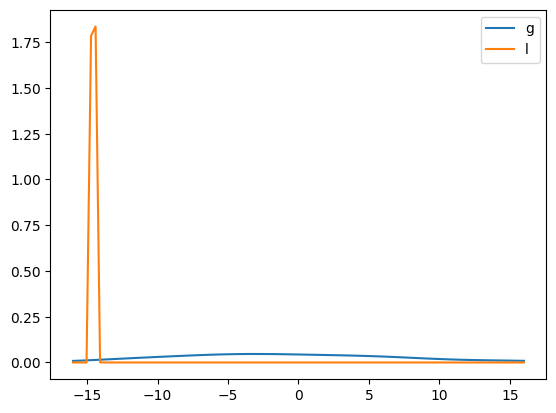

score: -2.652556439772045
best trial is 101
[TRIAL: 0141]##########


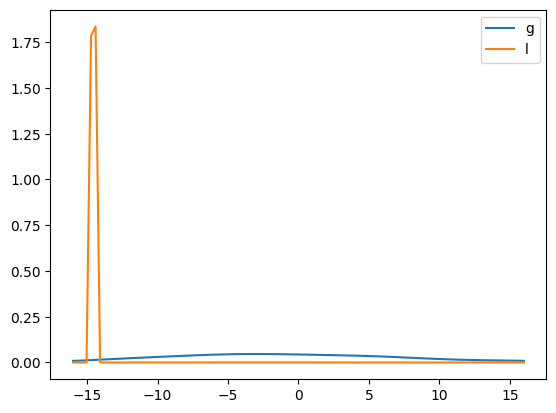

score: -64.47933029325446
best trial is 101
[TRIAL: 0142]##########


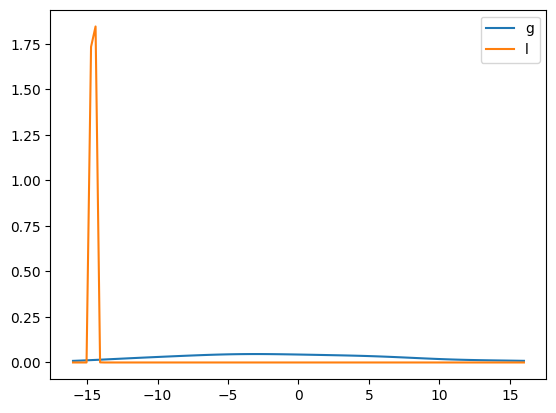

score: -63.30555821914528
best trial is 101
[TRIAL: 0143]##########


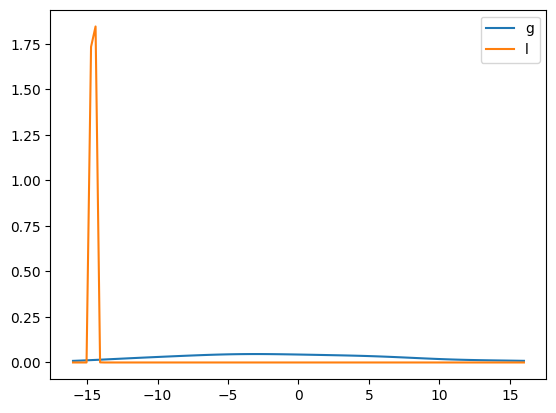

score: -62.47000714019829
best trial is 101
[TRIAL: 0144]##########


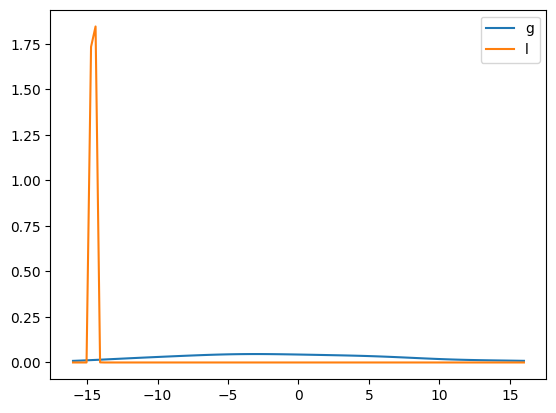

score: -64.0797468090365
best trial is 101
[TRIAL: 0145]##########


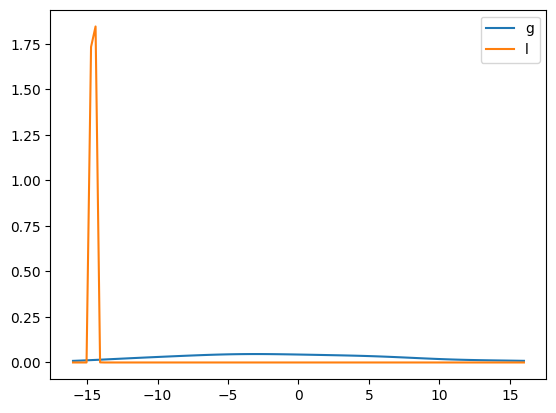

score: -65.31519063364404
best trial is 157
[TRIAL: 0146]##########


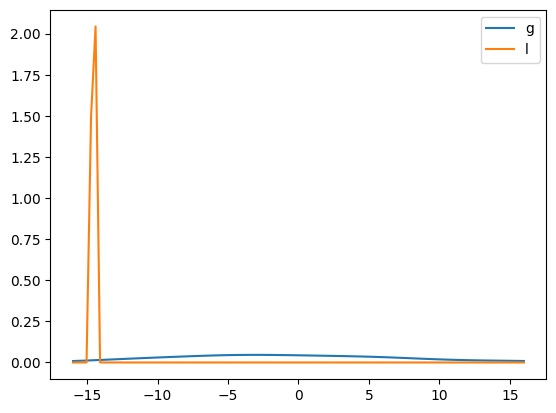

score: -64.9511094525404
best trial is 157
[TRIAL: 0147]##########


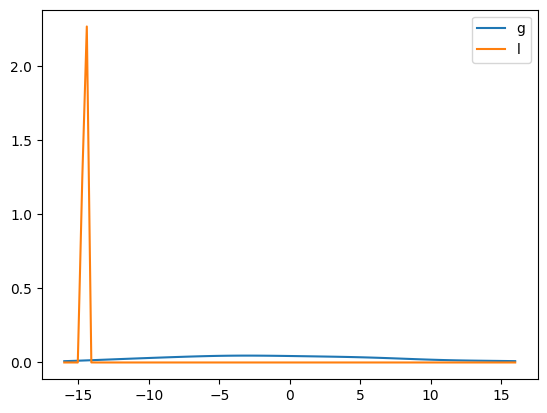

score: -65.06582912689916
best trial is 157
[TRIAL: 0148]##########


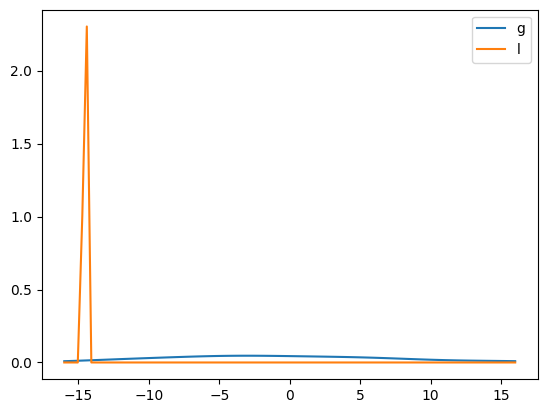

score: -48.6239231262913
best trial is 157
[TRIAL: 0149]##########


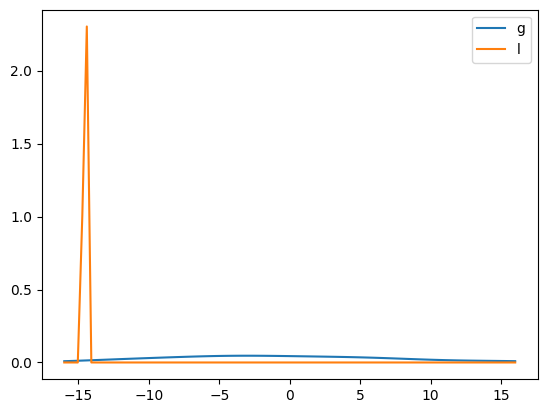

score: -61.978798398726745
best trial is 157
[TRIAL: 0150]##########


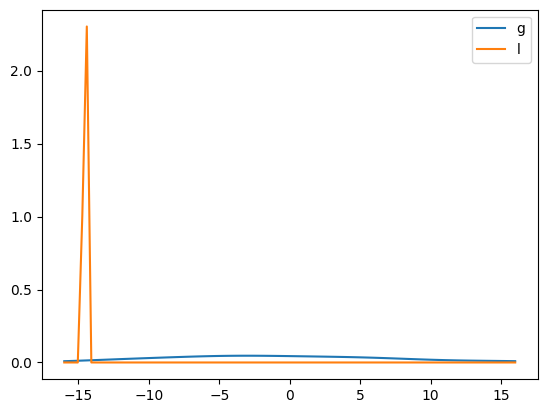

score: -2.1974421423574193
best trial is 157
[TRIAL: 0151]##########


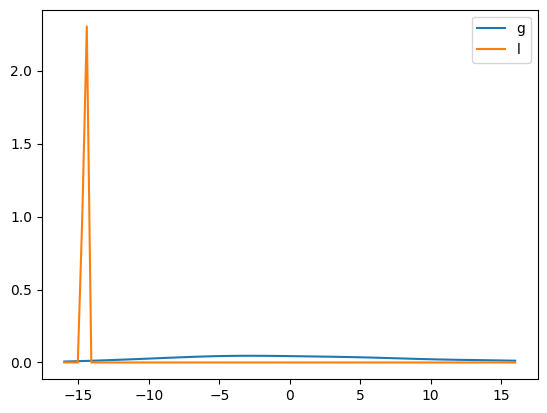

score: -1.0666367374593249
best trial is 157
[TRIAL: 0152]##########


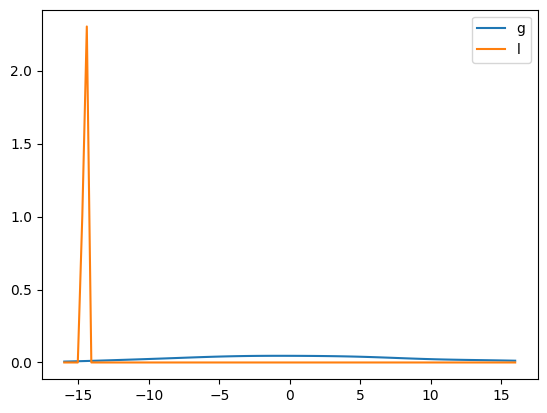

score: -8.504456924810395
best trial is 157
[TRIAL: 0153]##########


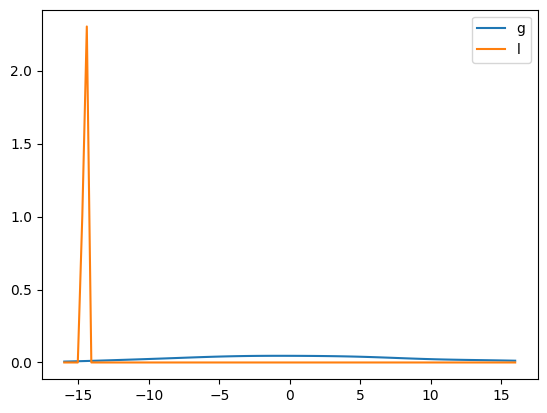

score: -65.26505751170862
best trial is 157
[TRIAL: 0154]##########


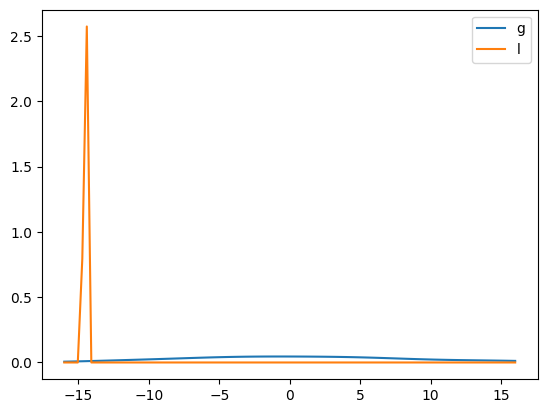

score: -60.33403192728721
best trial is 157
[TRIAL: 0155]##########


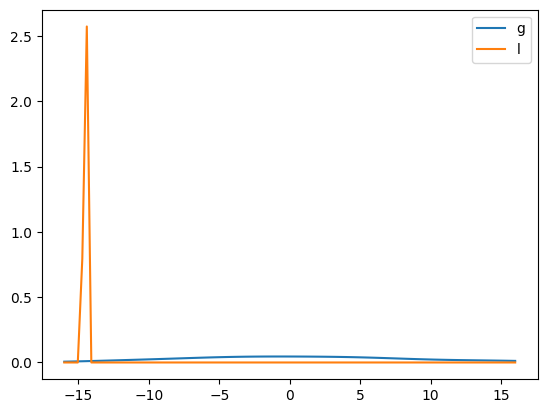

score: -27.18701241222709
best trial is 157
[TRIAL: 0156]##########


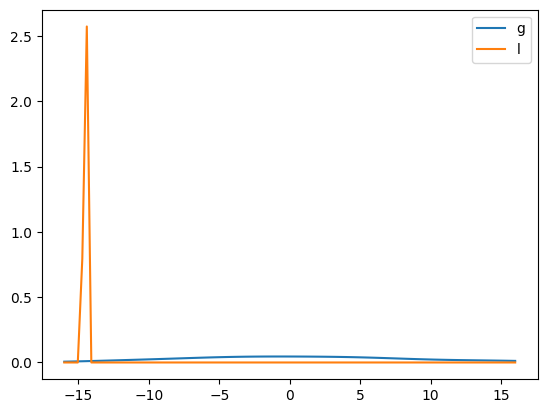

score: -65.26519976263778
best trial is 157
[TRIAL: 0157]##########


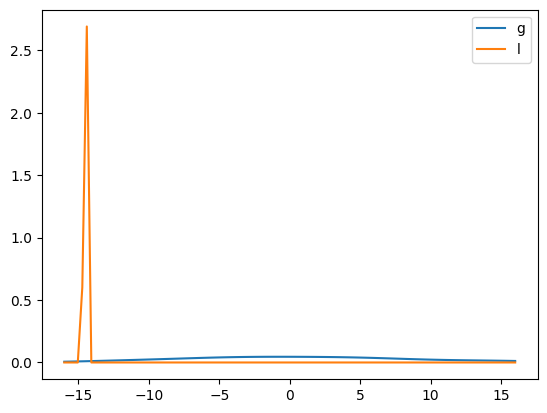

score: -8.305552243084017
best trial is 157
[TRIAL: 0158]##########


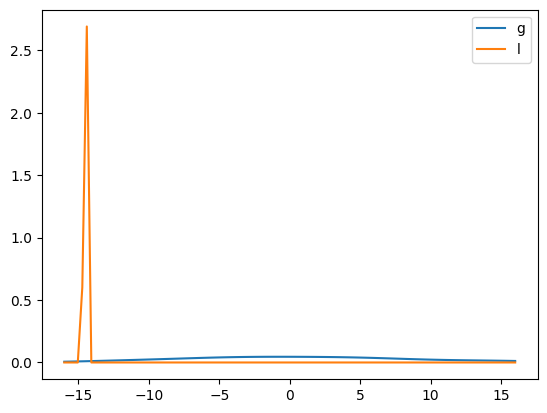

score: -64.08236704397581
best trial is 157
[TRIAL: 0159]##########


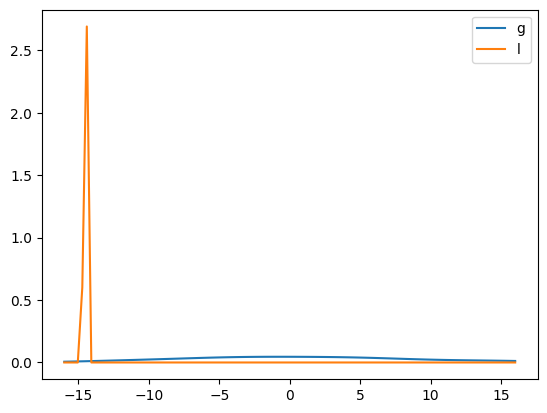

score: -64.2984133560406
best trial is 157
[TRIAL: 0160]##########


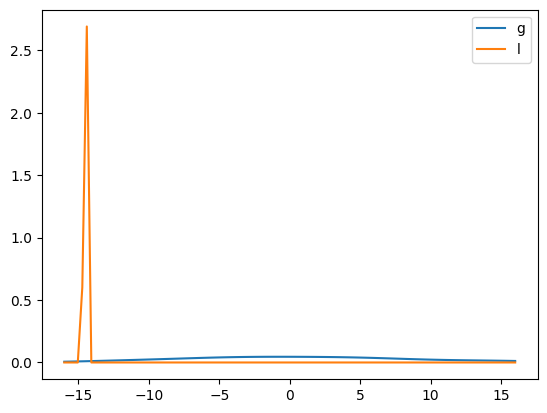

score: -61.64090581375741
best trial is 157
[TRIAL: 0161]##########


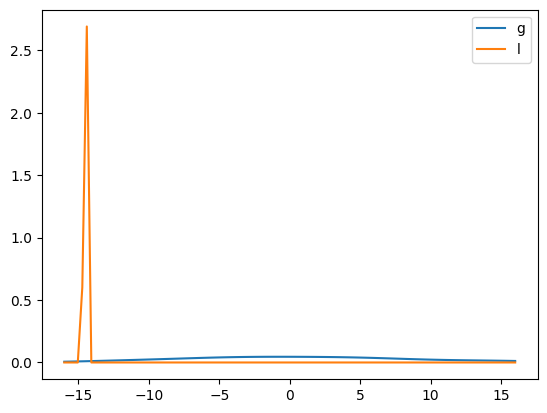

score: -5.532756511499441
best trial is 157
[TRIAL: 0162]##########


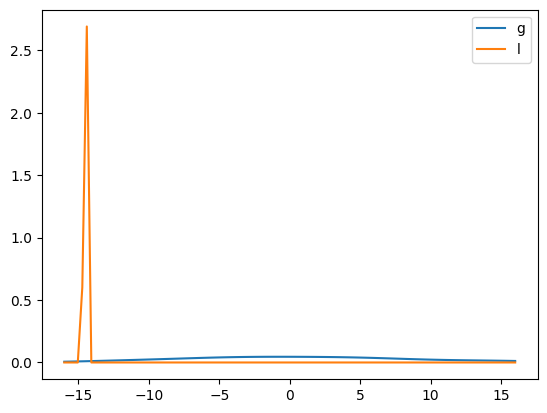

score: -64.87635002373821
best trial is 157
[TRIAL: 0163]##########


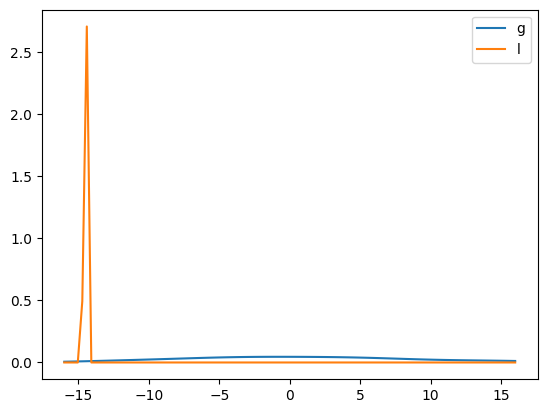

score: -1.8027999024571117
best trial is 157
[TRIAL: 0164]##########


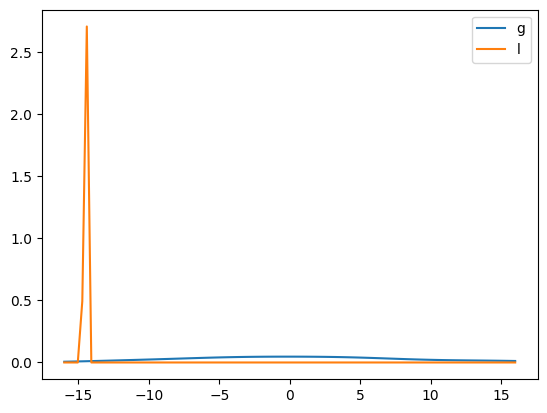

score: -63.72819918838624
best trial is 157
[TRIAL: 0165]##########


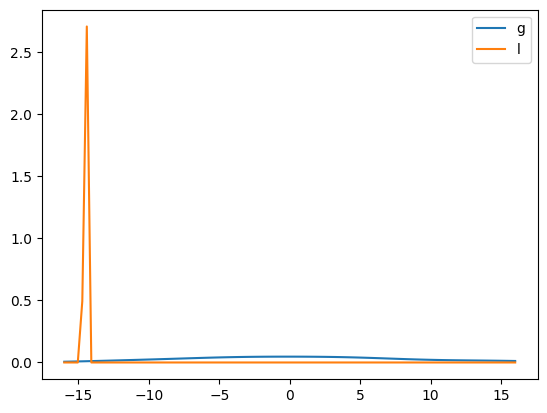

score: -65.18318928194641
best trial is 157
[TRIAL: 0166]##########


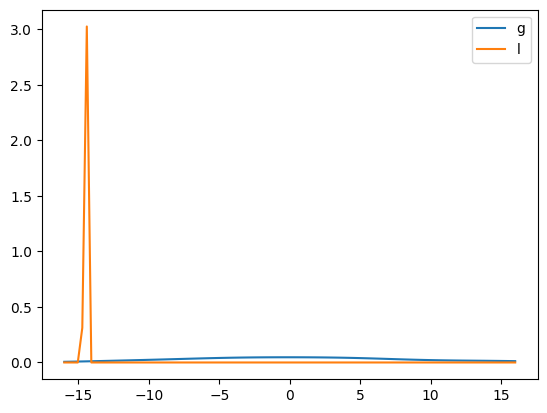

score: -65.00081626294644
best trial is 157
[TRIAL: 0167]##########


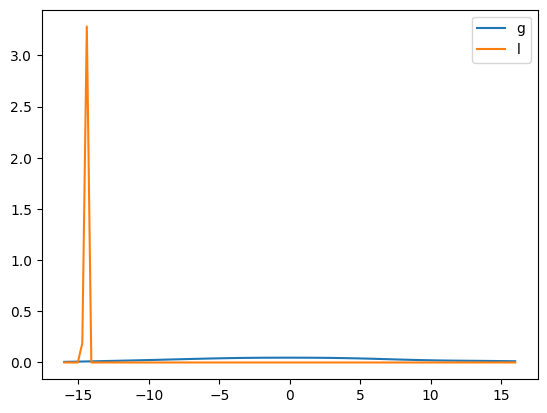

score: 2.994064201760207
best trial is 157
[TRIAL: 0168]##########


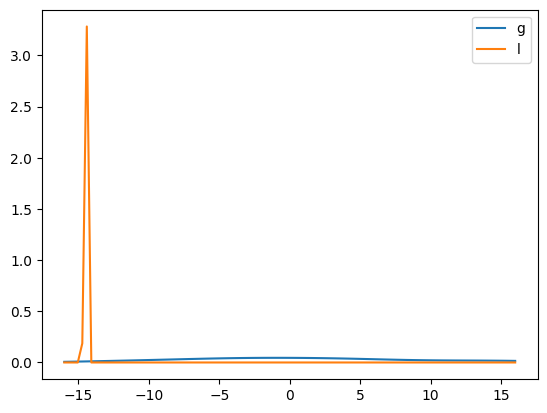

score: -64.6039255203864
best trial is 157
[TRIAL: 0169]##########


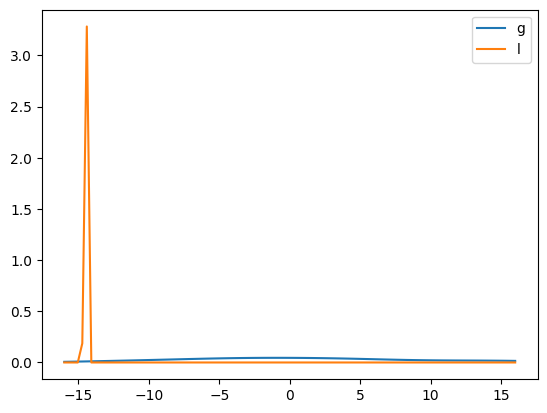

score: -62.41669039864135
best trial is 157
[TRIAL: 0170]##########


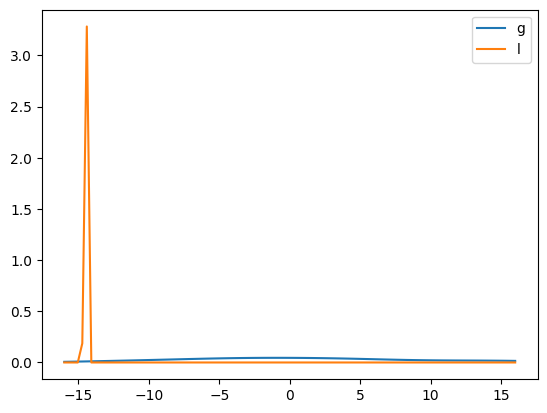

score: -65.23324979372556
best trial is 157
[TRIAL: 0171]##########


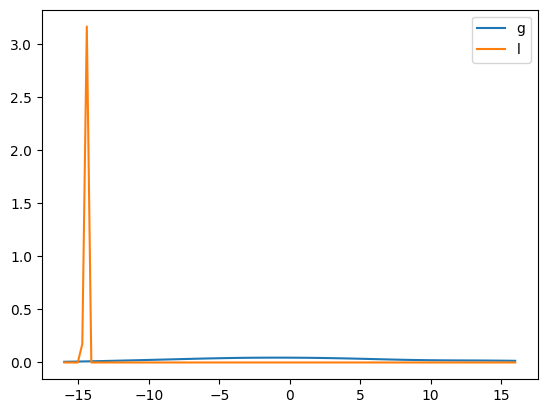

score: -63.561592297451206
best trial is 157
[TRIAL: 0172]##########


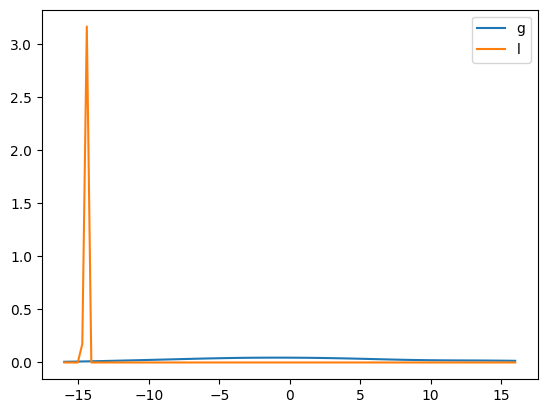

score: -0.3848109493297562
best trial is 157
[TRIAL: 0173]##########


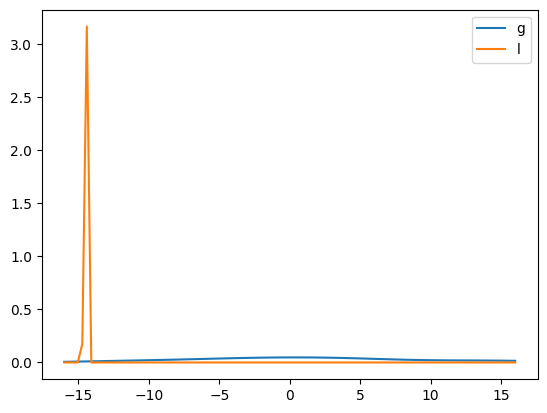

score: -64.09570287707129
best trial is 157
[TRIAL: 0174]##########


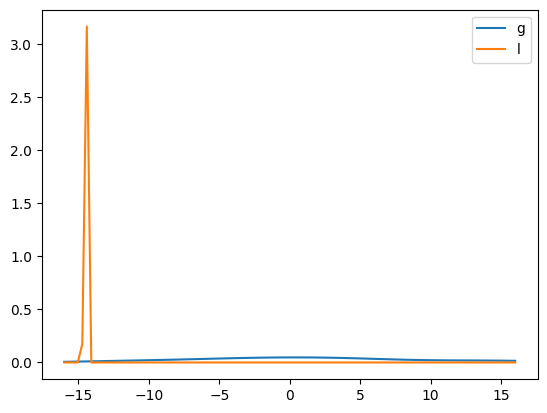

score: -62.579286178252126
best trial is 157
[TRIAL: 0175]##########


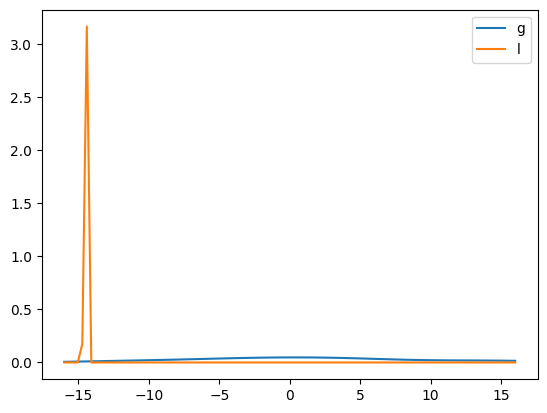

score: -63.30360195752073
best trial is 157
[TRIAL: 0176]##########


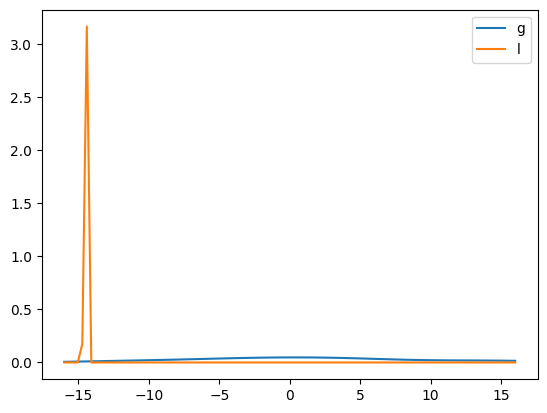

score: -64.10786693419838
best trial is 157
[TRIAL: 0177]##########


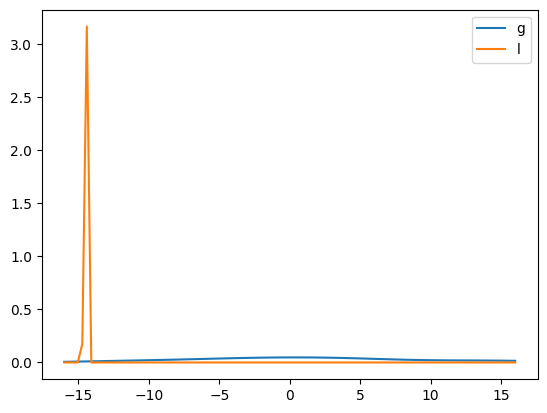

score: -65.1013512575983
best trial is 157
[TRIAL: 0178]##########


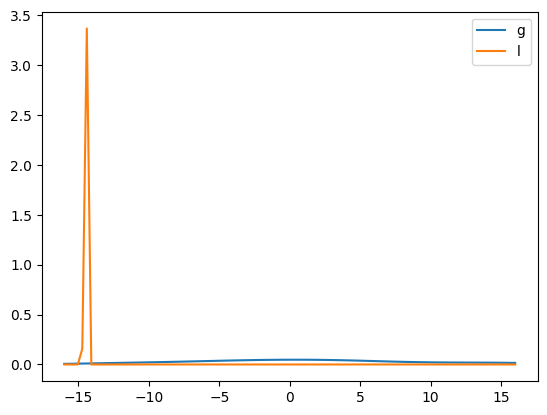

score: -63.94529060936087
best trial is 157
[TRIAL: 0179]##########


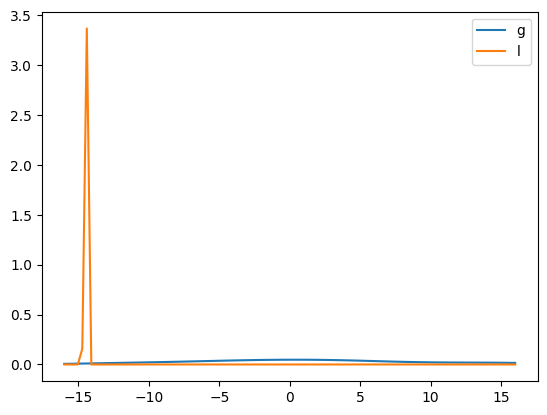

score: -13.920203272254312
best trial is 157
[TRIAL: 0180]##########


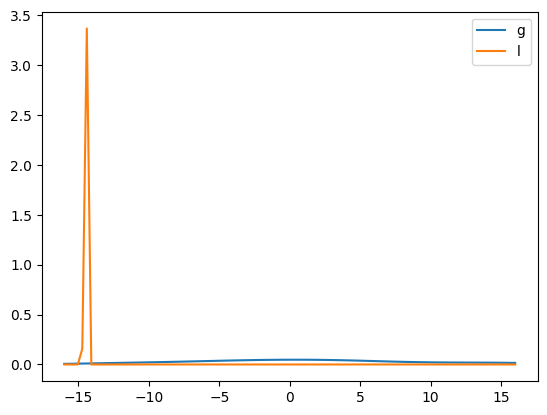

score: -1.3711193547946718
best trial is 157
[TRIAL: 0181]##########


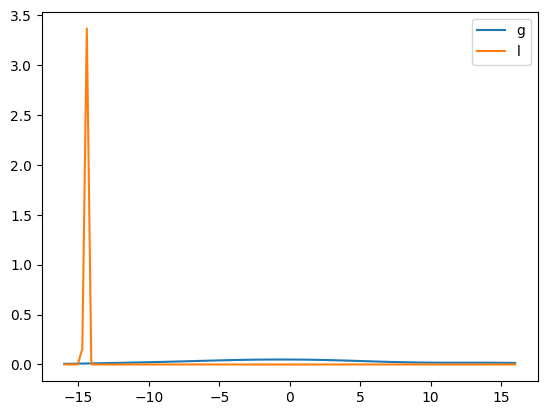

score: -65.23829810834577
best trial is 157
[TRIAL: 0182]##########


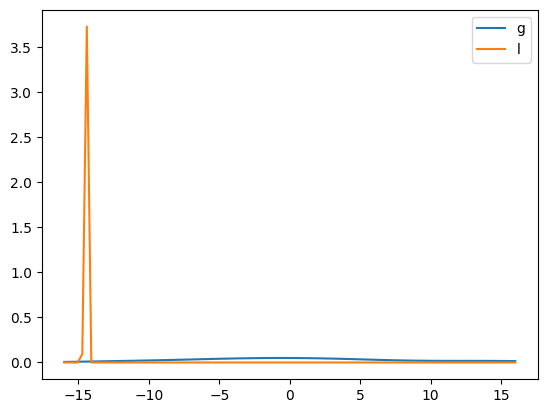

score: -1.2473895626398568
best trial is 157
[TRIAL: 0183]##########


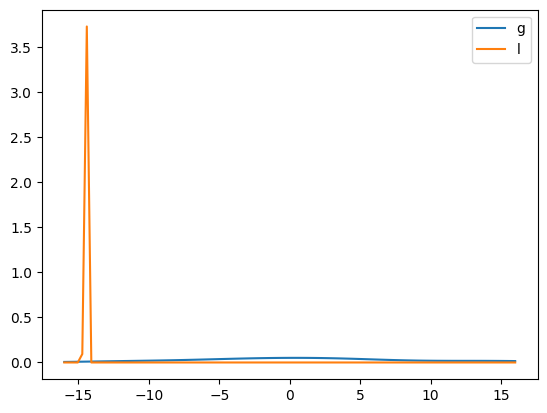

score: -9.98969698905145
best trial is 157
[TRIAL: 0184]##########


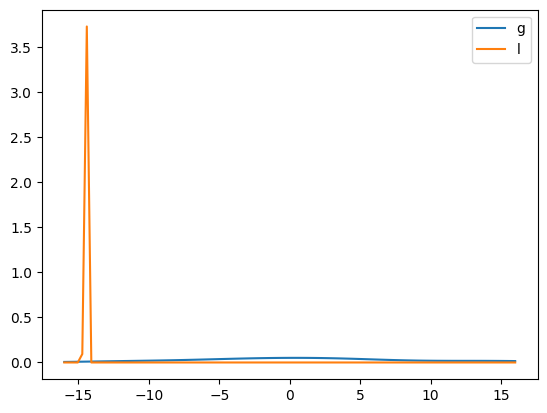

score: -64.99724567533735
best trial is 157
[TRIAL: 0185]##########


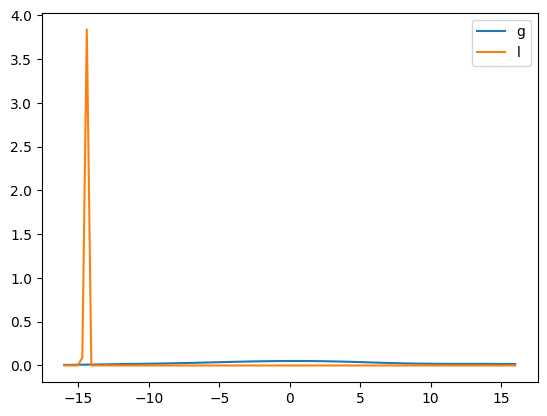

score: -65.26338098699422
best trial is 157
[TRIAL: 0186]##########


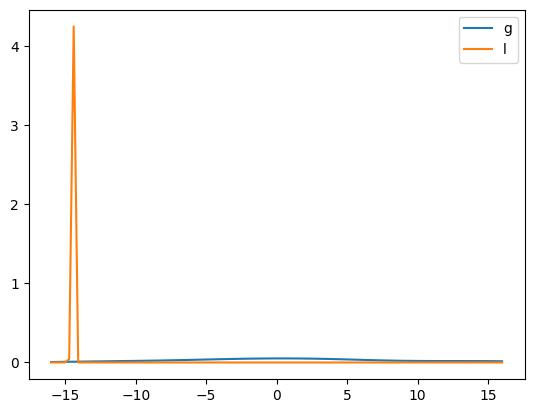

score: -9.783247521213173
best trial is 157
[TRIAL: 0187]##########


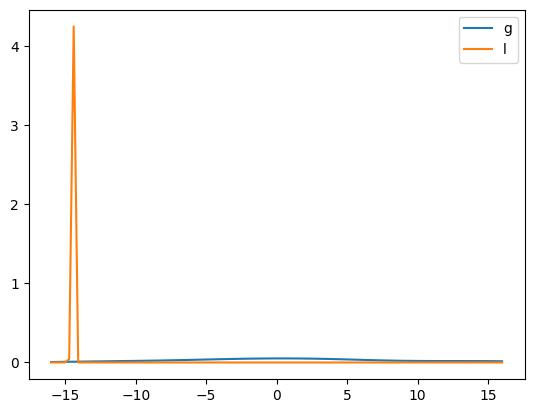

score: -63.967412120911334
best trial is 157
[TRIAL: 0188]##########


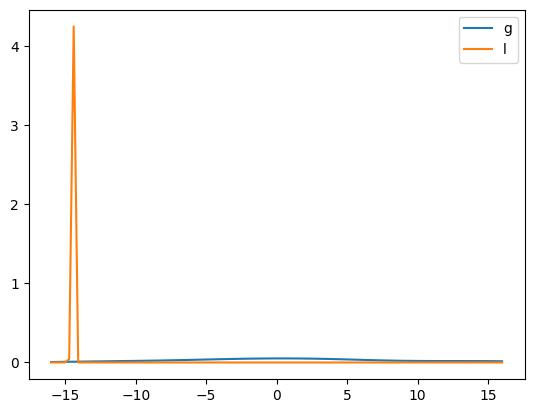

score: -65.26348517330865
best trial is 157
[TRIAL: 0189]##########


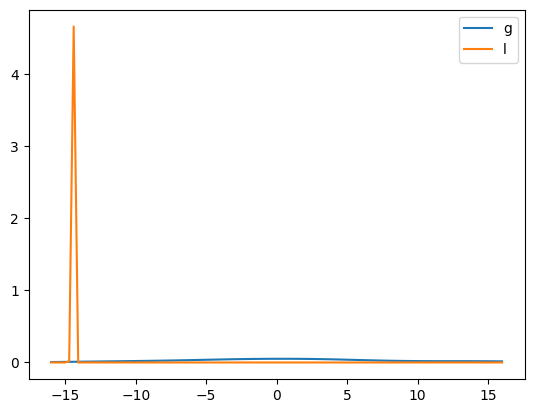

score: -63.48635282934518
best trial is 157
[TRIAL: 0190]##########


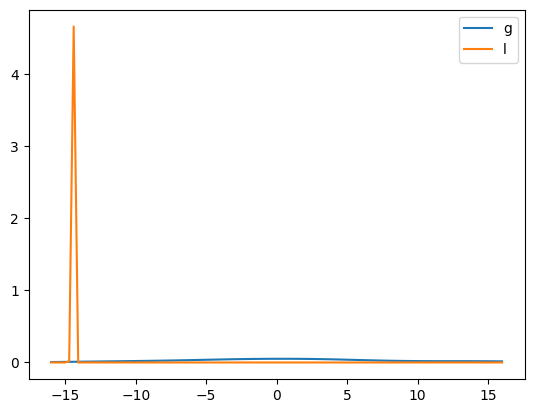

score: -26.782871976712627
best trial is 157


In [61]:
np.random.seed(seed=SEED)

x_init = np.array([-12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12])
y_init = BBF(x_init)
print(x_init)

tpe_params = {
    "data_x" : x_init, 
    "data_y": y_init,
    "gamma": GAMMA,
    "seed": SEED,
    "n_trial": N_LOOP,
    "n_suggest": N_SUGGEST,
    "kernel": KERNEL,
    "objective": objective,
}

tpe = TPE(**tpe_params)
tpe.search()

目的関数のx=-15付近の最小値を見つけることができました。

## Reference
[1] https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf  
[2] http://ibis.t.u-tokyo.ac.jp/suzuki/lecture/2015/dataanalysis/L9.pdf  
[3]